In [16]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import math
import csv
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
import matplotlib.pyplot as plt
import pylab as plt
import plotly.plotly as py
import plotly
import plotly.graph_objs as go
from scipy.stats.stats import pearsonr   
from sklearn import linear_model, datasets
import itertools
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats

In [125]:
#########################################################################
##[FUNCTION] data_creation simulates data for a given number of 
## individuals(indiv) over a set amount of time (max_time), and can 
## include as many covariates as desired (number_of_covariates)

## -- need to create the functionality for multiple covariates

#########################################################################


def data_creation2(indiv, max_time, number_of_covariates, Y_full, alpha, beta): 

    columns = ["indiv", "time","U", "A", "Y",  "L1"]
    df = pd.DataFrame(columns = columns)
     
    ## creating an unobserved variable that affects covariates 
    U = np.random.uniform(low = 0.1, high = 1, size = indiv)
            
    for jj in range(0, max_time+1): 
        if jj == 0: 
            x_L = alpha[0] + alpha[5]*U 
            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))

            x_A = beta[0] + beta[1]*L1 
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            df = pd.DataFrame({"indiv":range(0,indiv), "time":jj,"U":U, "A":A, \
                 "Y":[math.nan]*indiv, "L1":L1})
            
        elif jj == 1: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"]\
                  [(df.time == jj-1)], [0.0]*indiv, df["A"][(df.time == jj-1)],\
                  [0.0]*indiv, U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv, L1, df["L1"]\
                  [(df.time == jj-1)],df["A"][(df.time == jj-1)], [0.0]*indiv ])), axis = 1)
                         
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            temp_df = pd.DataFrame({"indiv":range(0,indiv), "time":jj, "U":U, "A":A,\
                      "Y":[math.nan]*indiv, "L1":L1})
            df = pd.concat([df, temp_df])

        else: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"][(df.time == jj-1)], \
                  df["L1"][(df.time == jj-2)], df["A"][(df.time == jj-1)], \
                  df["A"][(df.time == jj-2)], U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv,L1,df["L1"][(df.time == jj-1)],\
                  df["A"][(df.time == jj-1)] , df["A"][(df.time == jj-2)]])), axis = 1)

            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            if jj == max_time: 
                # x_Y = U + 0.5
                x_Y = [-1]*indiv + U + A + df.groupby(["indiv"]).A.mean()
                print(x_Y) 
                Y = np.random.binomial(n=1, p = np.exp(x_Y)/(1+np.exp(x_Y)))                
                temp_df = pd.DataFrame({"indiv":range(0,indiv), "time":jj,"U":U, "A":A, \
                          "Y":Y, "L1":L1})
                df = pd.concat([df, temp_df])


            else: 
                temp_df = pd.DataFrame({"indiv":range(0,indiv), "time":jj,"U":U, "A":A, \
                          "Y":[math.nan]*indiv, "L1":L1})
                df = pd.concat([df, temp_df])


    # creating shifted values 
    if Y_full == True:
        for kk in range(1,max_time+1):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
    else:
        for kk in range(1,4):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
            
    df.sort_values(by=['time', 'indiv'], ascending=[True, True])

    return(df); 

In [127]:
df = data_creation2(1000,11, 1, True, alpha, beta)
np.mean(df.Y)

indiv
0      1.455006
1      1.032166
2      1.799593
3      1.869732
4      1.224657
5      1.819772
6      1.088233
7      1.498200
8      0.976546
9      0.174255
10     0.504072
11     1.009524
12     1.691953
13     1.783962
14     0.987393
15     1.864747
16     1.925668
17     1.250243
18     1.470642
19     1.570262
20     1.253917
21     1.772719
22     1.784455
23     1.391265
24     1.727963
25     1.816340
26     0.867515
27     0.829843
28     1.235823
29     1.712902
         ...   
970    1.811226
971    1.121301
972    1.694614
973    1.494603
974    1.902020
975    1.582655
976    1.249265
977    0.464918
978    1.540963
979    1.304674
980    1.738924
981    1.653263
982    1.153855
983    1.144159
984    1.404034
985    1.889207
986    1.592998
987    1.716953
988    1.377613
989    1.453912
990    1.597748
991    1.304760
992    1.004980
993    0.784123
994    0.892964
995    1.293145
996    1.430552
997    1.501765
998    0.899255
999    0.852997
Name: A, dtype: fl

0.78

In [123]:
#########################################################################
##[FUNCTION] Y_model_creation creates the linear regression model for 
## the observed Ys based on the treatments (A) and covariates (L)  

#########################################################################

def Y_model_creation(df, max_time): 
    temp_df = df[df.time == max_time]
    # train_columns ='+'.join(map(str, np.append(list(df)[0:2],list(df)[6:])))
    train_columns = list(df)[0:2]+list(df)[6:]
    temp_df = temp_df.astype(float)
    # Y_model = smf.ols("Y~"+train_columns, data=temp_df).fit(); 
    Y_model = sm.Logit(np.asarray(temp_df["Y"]), \
                       np.asarray(sm.add_constant(temp_df[train_columns]))).fit(); 
    return(Y_model)

In [124]:
#########################################################################
##[FUNCTION] covariate_model_creation creates the logistic regression 
## for the observed covariate (L) data from the previous covariates 
## and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
## SHOULD THIS BE FOR ALL HISTORY UP TO THAT POINT TO BE MORE 
## ACCURATE WHEN CALCULATING THE EXPECTATION??? 

#########################################################################


def covariate_model_creation(df, max_time): 
    train_columns = ["L1_1", "L1_2", "L1_3", "A_1", "A_2",  "A_3"]
    L1_model = {}
    poly = PolynomialFeatures(1)

    for ii in range(1, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 1: 
            x = temp_df[["L1_1", "A_1"]]
            # L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), poly.fit_transform(x)).fit(); 
        elif ii == 2: 
            x = temp_df[["L1_1", "L1_2", \
                       "A_1", "A_2"]]
            # L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), \
                       # poly.fit_transform(x)).fit(); 
        else: 
            x = temp_df[train_columns]
            # L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), \
                       # np.asarray(sm.add_constant())).fit(); 
        L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), \
                       poly.fit_transform(x)).fit(); 
    return(L1_model)

In [95]:
#########################################################################
##[FUNCTION] treatment_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
#########################################################################


def treatment_model_creation(df, max_time): 
    train_columns = ["L1", "L1_1", "L1_2", "A_1", "A_2", "A_3"]
    A_model = {}
    poly = PolynomialFeatures(1)
            
    for ii in range(0, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 0: 
            x = temp_df[["L1"]]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), sm.add_constant(x, has_constant = "add")).fit()
        elif ii == 1: 
            x = temp_df[["L1", "L1_1", "A_1"]]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), poly.fit_transform(x)).fit()
        elif ii == 2:
            x = temp_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), poly.fit_transform(x)).fit()
        else: 
            x = temp_df[train_columns]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), poly.fit_transform(x)).fit()
    return(A_model)


In [6]:
#########################################################################
##[FUNCTION] simulation_run calculates the causal effect over an  
## established number of repetitions using the models for outcome (Y) 
## and the covariates (L) 

## -- need to create the functionality for multiple covariates

#########################################################################


def simulation_run2(df, Y_model, L1_model_df, max_time, Y_full, test_value): 
    reps = 10000
    final_results = np.empty(reps) 

    ### establishing treatment of interest
    A_test = [test_value]*(max_time+1) 

    values = pd.DataFrame(np.random.choice(np.array(df["L1"][df["time"] == 0]), reps))
    prod = np.empty(reps) 
    
    prod[np.where(values[0] == 0)] = 1-np.mean(list(df["L1"][df["time"] == 0]))
    prod[np.where(values[0] != 0)] = np.mean(list(df["L1"][df["time"] == 0]))

    values[1] = np.sum(np.array([L1_model_df.ix[0,][i] for i in [1,2,5]])*np.transpose(\
                np.array([[1.0]*reps,list(values[0]),[A_test[0]]*reps])), axis = 1)
    p_v = np.exp(values[1])/(1+np.exp(values[1]))
    values[1] = np.random.binomial(n=1, p = p_v)
    prod = prod*p_v
    
    values[2] = np.sum(np.array([L1_model_df.ix[1,][i] for i in [1,2,3,5,6]])*\
                np.transpose(np.array([[1.0]*reps, list(values[1]),list(values[0]), \
                [A_test[1]]*reps, [A_test[0]]*reps])), axis = 1 )
    p_v = (np.exp(values[2])/(1+np.exp(values[2]))) 
    values[2] = np.random.binomial(n=1, p=p_v)
    prod = prod*p_v
    
                                                               

    for jj in range(3, max_time+1):
        values[jj] = np.sum(np.array([L1_model_df.ix[jj-1,][i] for i in range(1,8)])\
                     *np.transpose(np.array([[1.0]*reps,list(values[jj-1]),\
                     list(values[jj-2]), list(values[jj-3]), [A_test[jj-1]]*reps, \
                     [A_test[jj-2]]*reps, [A_test[jj-3]]*reps])), axis = 1)
        p_v = (np.exp(values[jj])/(1+np.exp(values[jj]))) 
        values[jj] = np.random.binomial(n=1, p=p_v)
        prod = prod*p_v

    if Y_full == "TRUE": 
        Y_A = [A_test]*reps
        Y_L = np.array(values)
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8,10,12,14,16,18,20,22,24]]), \
                axis = 1)+np.sum([Y_model.params[i] for i in \
                [2,3,5,7,9,11,13,15,17,19,21,23]]*Y_L, axis = 1)
        Y_exp = sp.special.expit(Y_exp)
        
    else: 
        Y_A = [A_test*4]*reps
        Y_L = np.array([values[0], values[1], values[2], values[3], values[4]])
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8]]), axis = 1)+np.sum(\
                [Y_model.params[i] for i in [2,3,5,7]]*Y_L, axis = 1)
        Y_exp = (np.exp(Y_exp)/(1+np.exp(Y_exp)))

    return(np.mean(prod*Y_exp)) 

In [7]:
#########################################################################
##[FUNCTION] pi_function creates the w_m function given the following:
## the alpha model of A_{m,i}, the dataframe, the time (m), and an 
## indicator of whether this is the correct or incorrect model 

## do I need to do something in here like 1-expit for those A_j == 0?? 
## i.e. what I did in the last line here 
#########################################################################

def pi_function(m, alpha_model, df, indiv, alpha_wrong): 
    product = [1]*indiv
    for jj in range(3, m+1):
        if alpha_wrong[jj] == False: 
            x = alpha_model[jj].predict(sm.add_constant(df[df.time == jj][["L1", "L1_1", "L1_2", "A_1", \
                "A_2"]], has_constant='add'))
        else: 
            x = alpha_model[jj].predict(sm.add_constant(df[df.time == jj][["L1_3", \
                "A_3"]], has_constant='add'))
        product = product*x
    
    x = np.array(np.divide([1]*indiv, product))
    x[np.where(df[df.time == m]["A_1"] == 0.0)] = 1 - x[np.where(df[df.time == m]["A_1"] == 0.0)]
    return(x)    

In [8]:
#########################################################################
##[FUNCTION] alpha_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) over all time periods and
## individuals 

## -- need to create the functionality for multiple covariates
#########################################################################


def alpha_model_creation(df, wrong): 
    temp_df = df[df["time"]>2.0]
    if wrong == True:
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1_3", "A_3"]], has_constant='add'))).fit()

    else: 
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant='add'))).fit()

    return(alpha_model)  

In [9]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]

    while(time_counter > 3.0): 
        
        time_df = df.loc[df.time == time_counter-1]
        time_df["T"] = np.array(T)
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi 
        if wrong_s_model == "TRUE":
            train_columns = list(time_df)[0:1]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1],["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
            y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
            z = '+'.join(map(str, y))
            reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
            reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))

        time_df = time_df.astype(float)
        S_model = smf.ols("T~"+reg_columns, data=time_df).fit()
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
                
        elif test_value == 0: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))

        time_df["pi"] = pi2
        T = sp.special.expit(S_model.predict(time_df[train_columns]))
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    
    return(np.nanmean(T), values)  

In [10]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model, int_term):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model == True:
            train_columns = list(time_df)[0:2] + list(time_df)[12:14]+["pi"]
            # train_columns = list(time_df)[0:1]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2],np.append(list(time_df)[12:14], ["pi"]))))
            # reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1], ["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            if int_term == True:
                x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
                y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
                z = '+'.join(map(str, y))
                reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
                reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
            else:
                reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
        time_df = time_df.astype(float)
        
        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == True:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model == True:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    return(np.nanmean(T), values)  

In [11]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin_time(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model, int_term):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model[time_counter-1] == True:
            train_columns = list(time_df)[0:2] + list(time_df)[12:14]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2],np.append(list(time_df)[12:14], ["pi"]))))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            if int_term == True:
                x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
                y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
                z = '+'.join(map(str, y))
                reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
                reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
            else:
                reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
        time_df = time_df.astype(float)
        
        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model[time_counter-1] == True:
                pi2 = pi2*alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model[time_counter-1] == True:
                pi2 = pi2*(1-alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    return(np.nanmean(T), values)  

In [17]:
## NEW OFFICIAL ALPHA AND BETA FOR EVERYTHING 
# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
# ALPHA = [ 0.58986656  0.95344212 -0.89822429 -0.95566697  0.67520365  2.46365403]
# BETA = [ 0.17868818  0.89069712  0.89037635  0.20497534  0.10442911]

In [85]:
indiv = 1000 
max_time = 11
num_sims = 10
alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]
df = data_creation2(indiv, max_time, 1, "TRUE", alpha, beta) 
alpha_model = alpha_model_creation(df,False)
[treatdr1, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, False, False, alpha_model)
[treatdr0, values] =  DR_estimate_creation_bin(0.0, max_time, df, indiv, False, False, alpha_model)
treatdr1 - treatdr0

Optimization terminated successfully.
         Current function value: 0.409421
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-0.018681009066687126

In [1194]:
## CONSTANTS 
alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 1000
# alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
# beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

results_effect_df2 = pd.DataFrame(columns = ["treatment_g1", "treatment_g0", "differenceg", 
                                            "treatment_dr1", "treatment_dr0", "differencedr",\
                "meanY", "meanA", "meanL1","meanU","corrYA", "corrYL1", "corrYU", \
                "corrAL1", "corrUL1", "corrAU"])

alpha_model_right = [False]*12
s_model_right = [False]*12

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta)
     
    Y_model = Y_model_creation(df, max_time)
    L1_model_df = covariate_model_creation(df, max_time)
    treatg1 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 1)
    treatg0 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 0)
    # results_g_form_df.loc[len(results_g_form_df)+1] = [treatg1, treatg0, treatg1-treatg0]

    # df = df.iloc[:,0:12]
    for kk in range(0,max_time+1):
        alpha_model_good[kk] = alpha_model_creation(df,alpha_model_right[kk])
        
    [treatdr1_bin, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, alpha_model_right, s_model_right, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, alpha_model_right, s_model_right, alpha_model_good, False)
    results_effect_df2.loc[len(results_effect_df2)+1] = [treatg1, treatg0, treatg1-treatg0, treatdr1_bin, treatdr0_bin, treatdr1_bin - treatdr0_bin]+list(values) 
    
results_effect_df2.to_csv("W_EFFECT_RESULTS2")
#results_g_form_df.to_csv("G_FORM_RESULTS_FINAL")
#results_dr_bin_df.to_csv("DR_BIN_EST_RESULTS_FINAL")
#results_dr_bin_int_df.to_csv("DR_BIN_INT_EST_RESULTS_FINAL")

0
Optimization terminated successfully.
         Current function value: 0.530271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551468


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1
Optimization terminated successfully.
         Current function value: 0.540230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530508


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



2
Optimization terminated successfully.
         Current function value: 0.558979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593530


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



3
Optimization terminated successfully.
         Current function value: 0.566220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585831


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4
Optimization terminated successfully.
         Current function value: 0.537613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564243


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



5
Optimization terminated successfully.
         Current function value: 0.534151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552180


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



6
Optimization terminated successfully.
         Current function value: 0.526141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576065


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



7
Optimization terminated successfully.
         Current function value: 0.499976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544163


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



8
Optimization terminated successfully.
         Current function value: 0.536740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560302


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



9
Optimization terminated successfully.
         Current function value: 0.543697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607216


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



10
Optimization terminated successfully.
         Current function value: 0.512553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547320

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



11
Optimization terminated successfully.
         Current function value: 0.550520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576747

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



12
Optimization terminated successfully.
         Current function value: 0.558149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550162

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



13
Optimization terminated successfully.
         Current function value: 0.533914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647408
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553032

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



14
Optimization terminated successfully.
         Current function value: 0.543272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554346

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



15
Optimization terminated successfully.
         Current function value: 0.534603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569266

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



16
Optimization terminated successfully.
         Current function value: 0.538157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.589618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567116

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



17
Optimization terminated successfully.
         Current function value: 0.515584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.557649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566665

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



18
Optimization terminated successfully.
         Current function value: 0.564981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603591

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



19
Optimization terminated successfully.
         Current function value: 0.525925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528007

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20
Optimization terminated successfully.
         Current function value: 0.559893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550581

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



21
Optimization terminated successfully.
         Current function value: 0.547353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572727

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



22
Optimization terminated successfully.
         Current function value: 0.553861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.609110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571606

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



23
Optimization terminated successfully.
         Current function value: 0.538044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.566582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558780

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



24
Optimization terminated successfully.
         Current function value: 0.524404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587104

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



25
Optimization terminated successfully.
         Current function value: 0.553596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548308

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



26
Optimization terminated successfully.
         Current function value: 0.558321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563918

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



27
Optimization terminated successfully.
         Current function value: 0.540954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589845

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



28
Optimization terminated successfully.
         Current function value: 0.517011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.566250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557173

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



29
Optimization terminated successfully.
         Current function value: 0.548069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541061

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



30
Optimization terminated successfully.
         Current function value: 0.558823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553516

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



31
Optimization terminated successfully.
         Current function value: 0.551379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547376

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



32
Optimization terminated successfully.
         Current function value: 0.526815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540032

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



33
Optimization terminated successfully.
         Current function value: 0.529296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551913

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



34
Optimization terminated successfully.
         Current function value: 0.554222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



35
Optimization terminated successfully.
         Current function value: 0.545829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585885

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



36
Optimization terminated successfully.
         Current function value: 0.528255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.603986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569812

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



37
Optimization terminated successfully.
         Current function value: 0.529909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580000

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



38
Optimization terminated successfully.
         Current function value: 0.553316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592228

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



39
Optimization terminated successfully.
         Current function value: 0.513458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605565

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



40
Optimization terminated successfully.
         Current function value: 0.541258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568060

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



41
Optimization terminated successfully.
         Current function value: 0.543127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549508

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



42
Optimization terminated successfully.
         Current function value: 0.544530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566720

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



43
Optimization terminated successfully.
         Current function value: 0.550058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556058

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



44
Optimization terminated successfully.
         Current function value: 0.556834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580070

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



45
Optimization terminated successfully.
         Current function value: 0.566026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576665

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



46
Optimization terminated successfully.
         Current function value: 0.537120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561461

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



47
Optimization terminated successfully.
         Current function value: 0.529894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



48
Optimization terminated successfully.
         Current function value: 0.524777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



49
Optimization terminated successfully.
         Current function value: 0.547639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566538

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



50
Optimization terminated successfully.
         Current function value: 0.541978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571507

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



51
Optimization terminated successfully.
         Current function value: 0.534639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559074

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



52
Optimization terminated successfully.
         Current function value: 0.526194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587977

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



53
Optimization terminated successfully.
         Current function value: 0.549405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561487

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



54
Optimization terminated successfully.
         Current function value: 0.547167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581111

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



55
Optimization terminated successfully.
         Current function value: 0.552321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575614

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



56
Optimization terminated successfully.
         Current function value: 0.518246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559384

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



57
Optimization terminated successfully.
         Current function value: 0.559347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571577

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



58
Optimization terminated successfully.
         Current function value: 0.532013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573271

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



59
Optimization terminated successfully.
         Current function value: 0.543388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557791

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



60
Optimization terminated successfully.
         Current function value: 0.562902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557674

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



61
Optimization terminated successfully.
         Current function value: 0.535687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525983

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



62
Optimization terminated successfully.
         Current function value: 0.546231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629847
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.546689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552163

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



63
Optimization terminated successfully.
         Current function value: 0.507644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570859

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



64
Optimization terminated successfully.
         Current function value: 0.523032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577254

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



65
Optimization terminated successfully.
         Current function value: 0.520991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.609931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556066

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



66
Optimization terminated successfully.
         Current function value: 0.533258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577969

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



67
Optimization terminated successfully.
         Current function value: 0.529297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562858

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



68
Optimization terminated successfully.
         Current function value: 0.554963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576884

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



69
Optimization terminated successfully.
         Current function value: 0.553534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537311

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



70
Optimization terminated successfully.
         Current function value: 0.545755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548260

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



71
Optimization terminated successfully.
         Current function value: 0.553386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577017

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



72
Optimization terminated successfully.
         Current function value: 0.533930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551753

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



73
Optimization terminated successfully.
         Current function value: 0.564835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.568642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563600

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



74
Optimization terminated successfully.
         Current function value: 0.562528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565311

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



75
Optimization terminated successfully.
         Current function value: 0.533978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578649

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



76
Optimization terminated successfully.
         Current function value: 0.555871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555072

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



77
Optimization terminated successfully.
         Current function value: 0.558033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586686

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



78
Optimization terminated successfully.
         Current function value: 0.531379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548587

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



79
Optimization terminated successfully.
         Current function value: 0.546138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535980

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



80
Optimization terminated successfully.
         Current function value: 0.584021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.514142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.576522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.571543

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



81
Optimization terminated successfully.
         Current function value: 0.531569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574630

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



82
Optimization terminated successfully.
         Current function value: 0.490342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563949

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



83
Optimization terminated successfully.
         Current function value: 0.531248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597497

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



84
Optimization terminated successfully.
         Current function value: 0.521510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536139

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



85
Optimization terminated successfully.
         Current function value: 0.527138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537919

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



86
Optimization terminated successfully.
         Current function value: 0.562618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585918

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



87
Optimization terminated successfully.
         Current function value: 0.551433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561503

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



88
Optimization terminated successfully.
         Current function value: 0.532627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.553460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549726

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



89
Optimization terminated successfully.
         Current function value: 0.557365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571055

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



90
Optimization terminated successfully.
         Current function value: 0.528926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580385

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



91
Optimization terminated successfully.
         Current function value: 0.537166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575593

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



92
Optimization terminated successfully.
         Current function value: 0.539046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548623

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



93
Optimization terminated successfully.
         Current function value: 0.546566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570680

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



94
Optimization terminated successfully.
         Current function value: 0.528356
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



95
Optimization terminated successfully.
         Current function value: 0.534147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540385

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



96
Optimization terminated successfully.
         Current function value: 0.562962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579726

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



97
Optimization terminated successfully.
         Current function value: 0.525197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580558

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



98
Optimization terminated successfully.
         Current function value: 0.543451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595491

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



99
Optimization terminated successfully.
         Current function value: 0.554958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563179

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



100
Optimization terminated successfully.
         Current function value: 0.556063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



101
Optimization terminated successfully.
         Current function value: 0.542875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56957

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



102
Optimization terminated successfully.
         Current function value: 0.520216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56477

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



103
Optimization terminated successfully.
         Current function value: 0.556499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56847

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



104
Optimization terminated successfully.
         Current function value: 0.526614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55552

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



105
Optimization terminated successfully.
         Current function value: 0.507443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.604194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.579450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53085

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



106
Optimization terminated successfully.
         Current function value: 0.505577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58684

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



107
Optimization terminated successfully.
         Current function value: 0.536588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57937

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



108
Optimization terminated successfully.
         Current function value: 0.516022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55591

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



109
Optimization terminated successfully.
         Current function value: 0.541417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55974

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



110
Optimization terminated successfully.
         Current function value: 0.563861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56338

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



111
Optimization terminated successfully.
         Current function value: 0.539059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.559901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56844

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



112
Optimization terminated successfully.
         Current function value: 0.557258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58285

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



113
Optimization terminated successfully.
         Current function value: 0.564710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55747

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



114
Optimization terminated successfully.
         Current function value: 0.549431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55742

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



115
Optimization terminated successfully.
         Current function value: 0.544003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57754

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



116
Optimization terminated successfully.
         Current function value: 0.528270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53211

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



117
Optimization terminated successfully.
         Current function value: 0.511004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58808

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



118
Optimization terminated successfully.
         Current function value: 0.524277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54488

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



119
Optimization terminated successfully.
         Current function value: 0.533702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58433

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



120
Optimization terminated successfully.
         Current function value: 0.563275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55304

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



121
Optimization terminated successfully.
         Current function value: 0.551005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55331

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



122
Optimization terminated successfully.
         Current function value: 0.545363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56820

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



123
Optimization terminated successfully.
         Current function value: 0.532717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55906

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



124
Optimization terminated successfully.
         Current function value: 0.562226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57721

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



125
Optimization terminated successfully.
         Current function value: 0.554331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57176

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



126
Optimization terminated successfully.
         Current function value: 0.529429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58353

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



127
Optimization terminated successfully.
         Current function value: 0.507006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.614357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56897

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



128
Optimization terminated successfully.
         Current function value: 0.544764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57080

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



129
Optimization terminated successfully.
         Current function value: 0.540978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57864

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



130
Optimization terminated successfully.
         Current function value: 0.559807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54832

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



131
Optimization terminated successfully.
         Current function value: 0.546045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55957

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



132
Optimization terminated successfully.
         Current function value: 0.536979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55888

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



133
Optimization terminated successfully.
         Current function value: 0.552327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57296

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



134
Optimization terminated successfully.
         Current function value: 0.559907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58219

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



135
Optimization terminated successfully.
         Current function value: 0.541045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57161

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



136
Optimization terminated successfully.
         Current function value: 0.541136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55570

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



137
Optimization terminated successfully.
         Current function value: 0.545207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56280

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



138
Optimization terminated successfully.
         Current function value: 0.548946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56466

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



139
Optimization terminated successfully.
         Current function value: 0.528756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.570060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55779

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



140
Optimization terminated successfully.
         Current function value: 0.518378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.625380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58619

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



141
Optimization terminated successfully.
         Current function value: 0.553326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58827

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



142
Optimization terminated successfully.
         Current function value: 0.553221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57366

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



143
Optimization terminated successfully.
         Current function value: 0.537674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59062

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



144
Optimization terminated successfully.
         Current function value: 0.547834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58826

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



145
Optimization terminated successfully.
         Current function value: 0.547727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57185

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



146
Optimization terminated successfully.
         Current function value: 0.531126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.619627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54765

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



147
Optimization terminated successfully.
         Current function value: 0.588282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59144

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



148
Optimization terminated successfully.
         Current function value: 0.540496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55996

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



149
Optimization terminated successfully.
         Current function value: 0.538102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.619434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56609

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



150
Optimization terminated successfully.
         Current function value: 0.519691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58594

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



151
Optimization terminated successfully.
         Current function value: 0.516666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57940

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



152
Optimization terminated successfully.
         Current function value: 0.513547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



153
Optimization terminated successfully.
         Current function value: 0.549682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54630

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



154
Optimization terminated successfully.
         Current function value: 0.540141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56979

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



155
Optimization terminated successfully.
         Current function value: 0.551503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54778

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



156
Optimization terminated successfully.
         Current function value: 0.559074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57493

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



157
Optimization terminated successfully.
         Current function value: 0.555806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55958

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



158
Optimization terminated successfully.
         Current function value: 0.533710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54848

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



159
Optimization terminated successfully.
         Current function value: 0.566203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55731

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



160
Optimization terminated successfully.
         Current function value: 0.546796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53254

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



161
Optimization terminated successfully.
         Current function value: 0.527594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55927

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



162
Optimization terminated successfully.
         Current function value: 0.522769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55418

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



163
Optimization terminated successfully.
         Current function value: 0.560114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56412

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



164
Optimization terminated successfully.
         Current function value: 0.548307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56336

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



165
Optimization terminated successfully.
         Current function value: 0.528459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55479

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



166
Optimization terminated successfully.
         Current function value: 0.519644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57428

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



167
Optimization terminated successfully.
         Current function value: 0.539203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56900

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



168
Optimization terminated successfully.
         Current function value: 0.559450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57323

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



169
Optimization terminated successfully.
         Current function value: 0.520751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58313

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



170
Optimization terminated successfully.
         Current function value: 0.553751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56192

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



171
Optimization terminated successfully.
         Current function value: 0.525752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58462

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



172
Optimization terminated successfully.
         Current function value: 0.546253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57067

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



173
Optimization terminated successfully.
         Current function value: 0.542525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54952

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



174
Optimization terminated successfully.
         Current function value: 0.526319
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58581

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



175
Optimization terminated successfully.
         Current function value: 0.553242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54719

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



176
Optimization terminated successfully.
         Current function value: 0.536430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55592

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



177
Optimization terminated successfully.
         Current function value: 0.548928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56242

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



178
Optimization terminated successfully.
         Current function value: 0.526344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56039

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



179
Optimization terminated successfully.
         Current function value: 0.548306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57964

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



180
Optimization terminated successfully.
         Current function value: 0.515200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.566355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58054

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



181
Optimization terminated successfully.
         Current function value: 0.546161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56363

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



182
Optimization terminated successfully.
         Current function value: 0.544360
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56877

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



183
Optimization terminated successfully.
         Current function value: 0.547098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.579244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56809

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



184
Optimization terminated successfully.
         Current function value: 0.559380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56908

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



185
Optimization terminated successfully.
         Current function value: 0.512079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57473

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



186
Optimization terminated successfully.
         Current function value: 0.504317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.617479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.566540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53462

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



187
Optimization terminated successfully.
         Current function value: 0.541095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56321

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



188
Optimization terminated successfully.
         Current function value: 0.535732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59153

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



189
Optimization terminated successfully.
         Current function value: 0.524080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56847

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



190
Optimization terminated successfully.
         Current function value: 0.528985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56204

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



191
Optimization terminated successfully.
         Current function value: 0.532352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58013

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



192
Optimization terminated successfully.
         Current function value: 0.539109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55718

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



193
Optimization terminated successfully.
         Current function value: 0.552569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55360

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



194
Optimization terminated successfully.
         Current function value: 0.529099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56823

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



195
Optimization terminated successfully.
         Current function value: 0.538729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57940

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



196
Optimization terminated successfully.
         Current function value: 0.527368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.561946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59000

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



197
Optimization terminated successfully.
         Current function value: 0.549019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.561813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54354

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



198
Optimization terminated successfully.
         Current function value: 0.554993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55441

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



199
Optimization terminated successfully.
         Current function value: 0.533529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56613

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



200
Optimization terminated successfully.
         Current function value: 0.542372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.570997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58884

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



201
Optimization terminated successfully.
         Current function value: 0.548577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54428

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



202
Optimization terminated successfully.
         Current function value: 0.548640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56999

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



203
Optimization terminated successfully.
         Current function value: 0.530901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56210

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



204
Optimization terminated successfully.
         Current function value: 0.546147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53465

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



205
Optimization terminated successfully.
         Current function value: 0.576563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53577

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



206
Optimization terminated successfully.
         Current function value: 0.516726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56491

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



207
Optimization terminated successfully.
         Current function value: 0.550844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57146

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



208
Optimization terminated successfully.
         Current function value: 0.542794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55135

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



209
Optimization terminated successfully.
         Current function value: 0.521197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54848

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



210
Optimization terminated successfully.
         Current function value: 0.534331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53638

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



211
Optimization terminated successfully.
         Current function value: 0.524175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55157

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



212
Optimization terminated successfully.
         Current function value: 0.542033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55516

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



213
Optimization terminated successfully.
         Current function value: 0.568811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54752

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



214
Optimization terminated successfully.
         Current function value: 0.551156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54167

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



215
Optimization terminated successfully.
         Current function value: 0.530001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55133

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



216
Optimization terminated successfully.
         Current function value: 0.525606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



217
Optimization terminated successfully.
         Current function value: 0.536876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55446

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



218
Optimization terminated successfully.
         Current function value: 0.528867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



219
Optimization terminated successfully.
         Current function value: 0.510247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55852

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



220
Optimization terminated successfully.
         Current function value: 0.539261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56779

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



221
Optimization terminated successfully.
         Current function value: 0.554750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58182

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



222
Optimization terminated successfully.
         Current function value: 0.527417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57751

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



223
Optimization terminated successfully.
         Current function value: 0.550913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58200

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



224
Optimization terminated successfully.
         Current function value: 0.563834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58243

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



225
Optimization terminated successfully.
         Current function value: 0.536517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55173

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



226
Optimization terminated successfully.
         Current function value: 0.522412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.619274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54509

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



227
Optimization terminated successfully.
         Current function value: 0.532425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55552

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



228
Optimization terminated successfully.
         Current function value: 0.547810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57611

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



229
Optimization terminated successfully.
         Current function value: 0.544855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58106

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



230
Optimization terminated successfully.
         Current function value: 0.520605
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55858

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



231
Optimization terminated successfully.
         Current function value: 0.558269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57474

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



232
Optimization terminated successfully.
         Current function value: 0.528883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56214

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



233
Optimization terminated successfully.
         Current function value: 0.559490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55320

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



234
Optimization terminated successfully.
         Current function value: 0.540875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57147

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



235
Optimization terminated successfully.
         Current function value: 0.522891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56108

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



236
Optimization terminated successfully.
         Current function value: 0.565157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55689

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



237
Optimization terminated successfully.
         Current function value: 0.560010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56243

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



238
Optimization terminated successfully.
         Current function value: 0.555773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58406

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



239
Optimization terminated successfully.
         Current function value: 0.541655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56963

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



240
Optimization terminated successfully.
         Current function value: 0.532065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58526

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



241
Optimization terminated successfully.
         Current function value: 0.526026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58308

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



242
Optimization terminated successfully.
         Current function value: 0.562638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58256

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



243
Optimization terminated successfully.
         Current function value: 0.539589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57587

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



244
Optimization terminated successfully.
         Current function value: 0.533981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59693

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



245
Optimization terminated successfully.
         Current function value: 0.547970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58874

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



246
Optimization terminated successfully.
         Current function value: 0.551627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55361

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



247
Optimization terminated successfully.
         Current function value: 0.572609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56112

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



248
Optimization terminated successfully.
         Current function value: 0.552525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54419

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



249
Optimization terminated successfully.
         Current function value: 0.557348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53931

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



250
Optimization terminated successfully.
         Current function value: 0.564491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56156

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



251
Optimization terminated successfully.
         Current function value: 0.539540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55519

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



252
Optimization terminated successfully.
         Current function value: 0.545207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55894

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



253
Optimization terminated successfully.
         Current function value: 0.525024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.625749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57957

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



254
Optimization terminated successfully.
         Current function value: 0.557047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54487

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



255
Optimization terminated successfully.
         Current function value: 0.547689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56346

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



256
Optimization terminated successfully.
         Current function value: 0.560333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56522

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



257
Optimization terminated successfully.
         Current function value: 0.534244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55297

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



258
Optimization terminated successfully.
         Current function value: 0.554400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55484

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



259
Optimization terminated successfully.
         Current function value: 0.541547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57160

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



260
Optimization terminated successfully.
         Current function value: 0.549752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56352

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



261
Optimization terminated successfully.
         Current function value: 0.560708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55278

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



262
Optimization terminated successfully.
         Current function value: 0.561380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55722

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



263
Optimization terminated successfully.
         Current function value: 0.516398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56657

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



264
Optimization terminated successfully.
         Current function value: 0.535539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55993

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



265
Optimization terminated successfully.
         Current function value: 0.494750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55683

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



266
Optimization terminated successfully.
         Current function value: 0.563329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56690

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



267
Optimization terminated successfully.
         Current function value: 0.547307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56473

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



268
Optimization terminated successfully.
         Current function value: 0.536482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.614837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54791

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



269
Optimization terminated successfully.
         Current function value: 0.531032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55173

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



270
Optimization terminated successfully.
         Current function value: 0.545847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56066

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



271
Optimization terminated successfully.
         Current function value: 0.542487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56194

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



272
Optimization terminated successfully.
         Current function value: 0.554079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



273
Optimization terminated successfully.
         Current function value: 0.557605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.523328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53430

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



274
Optimization terminated successfully.
         Current function value: 0.570124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55812

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



275
Optimization terminated successfully.
         Current function value: 0.514519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55667

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



276
Optimization terminated successfully.
         Current function value: 0.563125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55158

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



277
Optimization terminated successfully.
         Current function value: 0.528276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58007

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



278
Optimization terminated successfully.
         Current function value: 0.555259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57407

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



279
Optimization terminated successfully.
         Current function value: 0.535999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58764

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



280
Optimization terminated successfully.
         Current function value: 0.527686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.658799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58313

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



281
Optimization terminated successfully.
         Current function value: 0.528208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634131
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55986

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



282
Optimization terminated successfully.
         Current function value: 0.540226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56353

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



283
Optimization terminated successfully.
         Current function value: 0.554943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57960

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



284
Optimization terminated successfully.
         Current function value: 0.548628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54441

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



285
Optimization terminated successfully.
         Current function value: 0.572364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55740

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



286
Optimization terminated successfully.
         Current function value: 0.557384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.552889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55207

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



287
Optimization terminated successfully.
         Current function value: 0.536075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57627

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



288
Optimization terminated successfully.
         Current function value: 0.553364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55624

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



289
Optimization terminated successfully.
         Current function value: 0.552301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.576870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58188

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



290
Optimization terminated successfully.
         Current function value: 0.563032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54564

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



291
Optimization terminated successfully.
         Current function value: 0.558462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56165

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



292
Optimization terminated successfully.
         Current function value: 0.541588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.570372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55402

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



293
Optimization terminated successfully.
         Current function value: 0.542292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.610273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59088

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



294
Optimization terminated successfully.
         Current function value: 0.536864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.651154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.565782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58640

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



295
Optimization terminated successfully.
         Current function value: 0.540182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56699

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



296
Optimization terminated successfully.
         Current function value: 0.527846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56126

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



297
Optimization terminated successfully.
         Current function value: 0.532052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57047

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



298
Optimization terminated successfully.
         Current function value: 0.558165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56834

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



299
Optimization terminated successfully.
         Current function value: 0.556126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56459

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



300
Optimization terminated successfully.
         Current function value: 0.532040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56655

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



301
Optimization terminated successfully.
         Current function value: 0.522950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58426

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



302
Optimization terminated successfully.
         Current function value: 0.540270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56552

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



303
Optimization terminated successfully.
         Current function value: 0.518159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58105

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



304
Optimization terminated successfully.
         Current function value: 0.545888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55439

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



305
Optimization terminated successfully.
         Current function value: 0.518174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56309

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



306
Optimization terminated successfully.
         Current function value: 0.539599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58042

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



307
Optimization terminated successfully.
         Current function value: 0.538541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58043

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



308
Optimization terminated successfully.
         Current function value: 0.545713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59431

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



309
Optimization terminated successfully.
         Current function value: 0.525796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59116

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



310
Optimization terminated successfully.
         Current function value: 0.522609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56927

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



311
Optimization terminated successfully.
         Current function value: 0.535465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.614890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57638

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



312
Optimization terminated successfully.
         Current function value: 0.542801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57633

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



313
Optimization terminated successfully.
         Current function value: 0.534134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55032

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



314
Optimization terminated successfully.
         Current function value: 0.538943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



315
Optimization terminated successfully.
         Current function value: 0.561175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57076

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



316
Optimization terminated successfully.
         Current function value: 0.574271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57124

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



317
Optimization terminated successfully.
         Current function value: 0.545872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



318
Optimization terminated successfully.
         Current function value: 0.536686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56780

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



319
Optimization terminated successfully.
         Current function value: 0.531162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54778

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



320
Optimization terminated successfully.
         Current function value: 0.524576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57301

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



321
Optimization terminated successfully.
         Current function value: 0.539123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53292

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



322
Optimization terminated successfully.
         Current function value: 0.514372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57673

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



323
Optimization terminated successfully.
         Current function value: 0.555054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56434

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



324
Optimization terminated successfully.
         Current function value: 0.548824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56301

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



325
Optimization terminated successfully.
         Current function value: 0.523296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54446

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



326
Optimization terminated successfully.
         Current function value: 0.529106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57381

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



327
Optimization terminated successfully.
         Current function value: 0.546078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54897

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



328
Optimization terminated successfully.
         Current function value: 0.537352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56566

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



329
Optimization terminated successfully.
         Current function value: 0.549305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58370

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



330
Optimization terminated successfully.
         Current function value: 0.541187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54020

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



331
Optimization terminated successfully.
         Current function value: 0.532891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56058

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



332
Optimization terminated successfully.
         Current function value: 0.533443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55776

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



333
Optimization terminated successfully.
         Current function value: 0.549076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55880

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



334
Optimization terminated successfully.
         Current function value: 0.531474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56913

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



335
Optimization terminated successfully.
         Current function value: 0.552007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53552

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



336
Optimization terminated successfully.
         Current function value: 0.532597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55288

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



337
Optimization terminated successfully.
         Current function value: 0.544462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57953

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



338
Optimization terminated successfully.
         Current function value: 0.529478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55694

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



339
Optimization terminated successfully.
         Current function value: 0.541774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57829

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



340
Optimization terminated successfully.
         Current function value: 0.535394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.498771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.581286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59205

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



341
Optimization terminated successfully.
         Current function value: 0.551541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55446

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



342
Optimization terminated successfully.
         Current function value: 0.525618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56949

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



343
Optimization terminated successfully.
         Current function value: 0.558523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54478

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



344
Optimization terminated successfully.
         Current function value: 0.521773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60035

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



345
Optimization terminated successfully.
         Current function value: 0.539732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55371

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



346
Optimization terminated successfully.
         Current function value: 0.531461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57440

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



347
Optimization terminated successfully.
         Current function value: 0.539476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55348

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



348
Optimization terminated successfully.
         Current function value: 0.516459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.574860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55824

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



349
Optimization terminated successfully.
         Current function value: 0.569206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58269

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



350
Optimization terminated successfully.
         Current function value: 0.533311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58274

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



351
Optimization terminated successfully.
         Current function value: 0.540516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57473

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



352
Optimization terminated successfully.
         Current function value: 0.542022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55922

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



353
Optimization terminated successfully.
         Current function value: 0.529857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



354
Optimization terminated successfully.
         Current function value: 0.533102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.553228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58182

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



355
Optimization terminated successfully.
         Current function value: 0.529829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53068

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



356
Optimization terminated successfully.
         Current function value: 0.556555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56099

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



357
Optimization terminated successfully.
         Current function value: 0.553476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.55464

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



358
Optimization terminated successfully.
         Current function value: 0.514952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57946

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



359
Optimization terminated successfully.
         Current function value: 0.549262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53830

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



360
Optimization terminated successfully.
         Current function value: 0.549181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55560

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



361
Optimization terminated successfully.
         Current function value: 0.584792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54232

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



362
Optimization terminated successfully.
         Current function value: 0.548245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59381

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



363
Optimization terminated successfully.
         Current function value: 0.558885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58357

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



364
Optimization terminated successfully.
         Current function value: 0.547058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58115

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



365
Optimization terminated successfully.
         Current function value: 0.533200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57337

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



366
Optimization terminated successfully.
         Current function value: 0.552723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54185

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



367
Optimization terminated successfully.
         Current function value: 0.527420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55525

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



368
Optimization terminated successfully.
         Current function value: 0.552826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56867

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



369
Optimization terminated successfully.
         Current function value: 0.551400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57439

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



370
Optimization terminated successfully.
         Current function value: 0.549989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55930

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



371
Optimization terminated successfully.
         Current function value: 0.530693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56115

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



372
Optimization terminated successfully.
         Current function value: 0.537514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55038

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



373
Optimization terminated successfully.
         Current function value: 0.536721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58559

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



374
Optimization terminated successfully.
         Current function value: 0.560984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55742

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



375
Optimization terminated successfully.
         Current function value: 0.532172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55988

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



376
Optimization terminated successfully.
         Current function value: 0.508876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55795

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



377
Optimization terminated successfully.
         Current function value: 0.542813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55616

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



378
Optimization terminated successfully.
         Current function value: 0.521671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56913

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



379
Optimization terminated successfully.
         Current function value: 0.559993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57545

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



380
Optimization terminated successfully.
         Current function value: 0.561316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56112

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



381
Optimization terminated successfully.
         Current function value: 0.523082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.619515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58053

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



382
Optimization terminated successfully.
         Current function value: 0.543278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56203

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



383
Optimization terminated successfully.
         Current function value: 0.545443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55872

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



384
Optimization terminated successfully.
         Current function value: 0.549081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55089

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



385
Optimization terminated successfully.
         Current function value: 0.544572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54961

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



386
Optimization terminated successfully.
         Current function value: 0.536631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.581685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54311

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



387
Optimization terminated successfully.
         Current function value: 0.550532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57521

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



388
Optimization terminated successfully.
         Current function value: 0.529652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58439

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



389
Optimization terminated successfully.
         Current function value: 0.525764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57161

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



390
Optimization terminated successfully.
         Current function value: 0.543752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54663

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



391
Optimization terminated successfully.
         Current function value: 0.546726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57053

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



392
Optimization terminated successfully.
         Current function value: 0.529995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55836

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



393
Optimization terminated successfully.
         Current function value: 0.534212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56858

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



394
Optimization terminated successfully.
         Current function value: 0.532533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.622942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.552569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54201

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



395
Optimization terminated successfully.
         Current function value: 0.534667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.602957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57597

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



396
Optimization terminated successfully.
         Current function value: 0.532368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.622592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56859

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



397
Optimization terminated successfully.
         Current function value: 0.551022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.625131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59872

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



398
Optimization terminated successfully.
         Current function value: 0.536194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58301

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



399
Optimization terminated successfully.
         Current function value: 0.542595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55372

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



400
Optimization terminated successfully.
         Current function value: 0.544601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55266

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



401
Optimization terminated successfully.
         Current function value: 0.517800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.56457

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



402
Optimization terminated successfully.
         Current function value: 0.512051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.590972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54698

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



403
Optimization terminated successfully.
         Current function value: 0.550131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58902

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



404
Optimization terminated successfully.
         Current function value: 0.549974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58174

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



405
Optimization terminated successfully.
         Current function value: 0.538642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57168

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



406
Optimization terminated successfully.
         Current function value: 0.528840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57411

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



407
Optimization terminated successfully.
         Current function value: 0.550907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56433

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



408
Optimization terminated successfully.
         Current function value: 0.533362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



409
Optimization terminated successfully.
         Current function value: 0.545204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54871

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



410
Optimization terminated successfully.
         Current function value: 0.530294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54290

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



411
Optimization terminated successfully.
         Current function value: 0.530661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55406

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



412
Optimization terminated successfully.
         Current function value: 0.536031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55711

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



413
Optimization terminated successfully.
         Current function value: 0.540867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57061

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



414
Optimization terminated successfully.
         Current function value: 0.534065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59132

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



415
Optimization terminated successfully.
         Current function value: 0.551387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58950

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



416
Optimization terminated successfully.
         Current function value: 0.515881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.602619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53977

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



417
Optimization terminated successfully.
         Current function value: 0.554635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.622124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55732

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



418
Optimization terminated successfully.
         Current function value: 0.537509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55120

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



419
Optimization terminated successfully.
         Current function value: 0.511842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58369

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



420
Optimization terminated successfully.
         Current function value: 0.518072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55418

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



421
Optimization terminated successfully.
         Current function value: 0.529571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58561

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



422
Optimization terminated successfully.
         Current function value: 0.538209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56488

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



423
Optimization terminated successfully.
         Current function value: 0.537299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57105

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



424
Optimization terminated successfully.
         Current function value: 0.533616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56825

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



425
Optimization terminated successfully.
         Current function value: 0.531879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.52758

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



426
Optimization terminated successfully.
         Current function value: 0.563701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57931

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



427
Optimization terminated successfully.
         Current function value: 0.549264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57805

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



428
Optimization terminated successfully.
         Current function value: 0.552586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57570

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



429
Optimization terminated successfully.
         Current function value: 0.545688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56740

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



430
Optimization terminated successfully.
         Current function value: 0.541720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57181

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



431
Optimization terminated successfully.
         Current function value: 0.546212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55415

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



432
Optimization terminated successfully.
         Current function value: 0.523683
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55203

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



433
Optimization terminated successfully.
         Current function value: 0.532604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58801

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



434
Optimization terminated successfully.
         Current function value: 0.536597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55601

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



435
Optimization terminated successfully.
         Current function value: 0.538028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.567395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57549

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



436
Optimization terminated successfully.
         Current function value: 0.541690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54636

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



437
Optimization terminated successfully.
         Current function value: 0.546143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



438
Optimization terminated successfully.
         Current function value: 0.559424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.554739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57771

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



439
Optimization terminated successfully.
         Current function value: 0.538140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55247

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



440
Optimization terminated successfully.
         Current function value: 0.515715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.625711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56158

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



441
Optimization terminated successfully.
         Current function value: 0.558458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58142

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



442
Optimization terminated successfully.
         Current function value: 0.542033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57798

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



443
Optimization terminated successfully.
         Current function value: 0.531366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57419

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



444
Optimization terminated successfully.
         Current function value: 0.547358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58520

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



445
Optimization terminated successfully.
         Current function value: 0.523670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55746

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



446
Optimization terminated successfully.
         Current function value: 0.526038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.553648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57094

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



447
Optimization terminated successfully.
         Current function value: 0.544336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58072

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



448
Optimization terminated successfully.
         Current function value: 0.548937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55442

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



449
Optimization terminated successfully.
         Current function value: 0.574718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56524

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



450
Optimization terminated successfully.
         Current function value: 0.508902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55916

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



451
Optimization terminated successfully.
         Current function value: 0.530631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56196

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



452
Optimization terminated successfully.
         Current function value: 0.541770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57044

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



453
Optimization terminated successfully.
         Current function value: 0.551851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.570088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56567

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



454
Optimization terminated successfully.
         Current function value: 0.551421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55993

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



455
Optimization terminated successfully.
         Current function value: 0.567849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57865

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



456
Optimization terminated successfully.
         Current function value: 0.524651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54792

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



457
Optimization terminated successfully.
         Current function value: 0.549039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56840

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



458
Optimization terminated successfully.
         Current function value: 0.560219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58474

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



459
Optimization terminated successfully.
         Current function value: 0.522577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55951

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



460
Optimization terminated successfully.
         Current function value: 0.523602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54605

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



461
Optimization terminated successfully.
         Current function value: 0.537108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57117

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



462
Optimization terminated successfully.
         Current function value: 0.538702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58762

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



463
Optimization terminated successfully.
         Current function value: 0.520222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57884

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



464
Optimization terminated successfully.
         Current function value: 0.548172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55498

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



465
Optimization terminated successfully.
         Current function value: 0.553498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56547

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



466
Optimization terminated successfully.
         Current function value: 0.539687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54819

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



467
Optimization terminated successfully.
         Current function value: 0.521982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57826

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



468
Optimization terminated successfully.
         Current function value: 0.567479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58186

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



469
Optimization terminated successfully.
         Current function value: 0.528273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53458

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



470
Optimization terminated successfully.
         Current function value: 0.559924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



471
Optimization terminated successfully.
         Current function value: 0.560925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56936

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



472
Optimization terminated successfully.
         Current function value: 0.543397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.523935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56958

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



473
Optimization terminated successfully.
         Current function value: 0.540055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57439

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



474
Optimization terminated successfully.
         Current function value: 0.554793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55125

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



475
Optimization terminated successfully.
         Current function value: 0.535428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56777

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



476
Optimization terminated successfully.
         Current function value: 0.564743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55635

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



477
Optimization terminated successfully.
         Current function value: 0.569907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54045

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



478
Optimization terminated successfully.
         Current function value: 0.530279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55521

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



479
Optimization terminated successfully.
         Current function value: 0.542870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59217

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



480
Optimization terminated successfully.
         Current function value: 0.539608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.614326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58823

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



481
Optimization terminated successfully.
         Current function value: 0.524521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59877

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



482
Optimization terminated successfully.
         Current function value: 0.548128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56599

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



483
Optimization terminated successfully.
         Current function value: 0.540662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54641

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



484
Optimization terminated successfully.
         Current function value: 0.537033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57073

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



485
Optimization terminated successfully.
         Current function value: 0.548144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55819

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



486
Optimization terminated successfully.
         Current function value: 0.528859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57283

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



487
Optimization terminated successfully.
         Current function value: 0.566358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58514

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



488
Optimization terminated successfully.
         Current function value: 0.555979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56296

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



489
Optimization terminated successfully.
         Current function value: 0.536161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58384

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



490
Optimization terminated successfully.
         Current function value: 0.540480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54509

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



491
Optimization terminated successfully.
         Current function value: 0.541390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53542

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



492
Optimization terminated successfully.
         Current function value: 0.546531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.561035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56223

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



493
Optimization terminated successfully.
         Current function value: 0.543663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.566538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57279

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



494
Optimization terminated successfully.
         Current function value: 0.560156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54812

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



495
Optimization terminated successfully.
         Current function value: 0.537132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57553

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



496
Optimization terminated successfully.
         Current function value: 0.527574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.567956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56553

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



497
Optimization terminated successfully.
         Current function value: 0.521687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



498
Optimization terminated successfully.
         Current function value: 0.539965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56737

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



499
Optimization terminated successfully.
         Current function value: 0.534432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59650

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



500
Optimization terminated successfully.
         Current function value: 0.544840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57083

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



501
Optimization terminated successfully.
         Current function value: 0.519504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55602

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



502
Optimization terminated successfully.
         Current function value: 0.546506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646377
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56468

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



503
Optimization terminated successfully.
         Current function value: 0.532494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56790

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



504
Optimization terminated successfully.
         Current function value: 0.532408
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55667

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



505
Optimization terminated successfully.
         Current function value: 0.521164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54003

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



506
Optimization terminated successfully.
         Current function value: 0.553110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56934

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



507
Optimization terminated successfully.
         Current function value: 0.562489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56898

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



508
Optimization terminated successfully.
         Current function value: 0.501347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55330

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



509
Optimization terminated successfully.
         Current function value: 0.523807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.617046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53686

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



510
Optimization terminated successfully.
         Current function value: 0.530942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57156

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



511
Optimization terminated successfully.
         Current function value: 0.538503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.625088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55644

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



512
Optimization terminated successfully.
         Current function value: 0.541890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.554874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54021

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



513
Optimization terminated successfully.
         Current function value: 0.560168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54540

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



514
Optimization terminated successfully.
         Current function value: 0.542023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57815

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



515
Optimization terminated successfully.
         Current function value: 0.533451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.612059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57824

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



516
Optimization terminated successfully.
         Current function value: 0.544896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53468

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



517
Optimization terminated successfully.
         Current function value: 0.534736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58130

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



518
Optimization terminated successfully.
         Current function value: 0.541836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.568421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55075

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



519
Optimization terminated successfully.
         Current function value: 0.524192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.563776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55508

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



520
Optimization terminated successfully.
         Current function value: 0.553975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56146

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



521
Optimization terminated successfully.
         Current function value: 0.556231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57334

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



522
Optimization terminated successfully.
         Current function value: 0.542582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57190

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



523
Optimization terminated successfully.
         Current function value: 0.568927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56490

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



524
Optimization terminated successfully.
         Current function value: 0.532465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644758
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57127

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



525
Optimization terminated successfully.
         Current function value: 0.541782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59516

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



526
Optimization terminated successfully.
         Current function value: 0.557858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55905

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



527
Optimization terminated successfully.
         Current function value: 0.515991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56836

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



528
Optimization terminated successfully.
         Current function value: 0.531973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58490

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



529
Optimization terminated successfully.
         Current function value: 0.573548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55872

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



530
Optimization terminated successfully.
         Current function value: 0.544725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55833

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



531
Optimization terminated successfully.
         Current function value: 0.524433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55521

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



532
Optimization terminated successfully.
         Current function value: 0.536097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54332

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



533
Optimization terminated successfully.
         Current function value: 0.516922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56585

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



534
Optimization terminated successfully.
         Current function value: 0.550702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57754

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



535
Optimization terminated successfully.
         Current function value: 0.551672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56508

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



536
Optimization terminated successfully.
         Current function value: 0.547864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58902

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



537
Optimization terminated successfully.
         Current function value: 0.535333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54969

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



538
Optimization terminated successfully.
         Current function value: 0.549050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54824

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



539
Optimization terminated successfully.
         Current function value: 0.523521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56927

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



540
Optimization terminated successfully.
         Current function value: 0.524557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57093

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



541
Optimization terminated successfully.
         Current function value: 0.535803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56714

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



542
Optimization terminated successfully.
         Current function value: 0.551813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57717

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



543
Optimization terminated successfully.
         Current function value: 0.509961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59572

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



544
Optimization terminated successfully.
         Current function value: 0.562552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56216

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



545
Optimization terminated successfully.
         Current function value: 0.519184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56022

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



546
Optimization terminated successfully.
         Current function value: 0.551750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55493

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



547
Optimization terminated successfully.
         Current function value: 0.527989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57404

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



548
Optimization terminated successfully.
         Current function value: 0.555283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55477

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



549
Optimization terminated successfully.
         Current function value: 0.538619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57229

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



550
Optimization terminated successfully.
         Current function value: 0.528867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55040

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



551
Optimization terminated successfully.
         Current function value: 0.507866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56893

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



552
Optimization terminated successfully.
         Current function value: 0.541140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55031

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



553
Optimization terminated successfully.
         Current function value: 0.539646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54232

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



554
Optimization terminated successfully.
         Current function value: 0.554920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57952

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



555
Optimization terminated successfully.
         Current function value: 0.516274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57083

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



556
Optimization terminated successfully.
         Current function value: 0.547364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56609

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



557
Optimization terminated successfully.
         Current function value: 0.526979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55469

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



558
Optimization terminated successfully.
         Current function value: 0.549320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58262

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



559
Optimization terminated successfully.
         Current function value: 0.577319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58557

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



560
Optimization terminated successfully.
         Current function value: 0.545853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56721

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



561
Optimization terminated successfully.
         Current function value: 0.559018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57267

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



562
Optimization terminated successfully.
         Current function value: 0.535561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55861

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



563
Optimization terminated successfully.
         Current function value: 0.527504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56206

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



564
Optimization terminated successfully.
         Current function value: 0.536138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56181

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



565
Optimization terminated successfully.
         Current function value: 0.531989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55658

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



566
Optimization terminated successfully.
         Current function value: 0.552854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53672

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



567
Optimization terminated successfully.
         Current function value: 0.540436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55808

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



568
Optimization terminated successfully.
         Current function value: 0.524602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



569
Optimization terminated successfully.
         Current function value: 0.527849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53440

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



570
Optimization terminated successfully.
         Current function value: 0.538916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56403

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



571
Optimization terminated successfully.
         Current function value: 0.528462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55123

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



572
Optimization terminated successfully.
         Current function value: 0.551043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58422

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



573
Optimization terminated successfully.
         Current function value: 0.524133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58846

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



574
Optimization terminated successfully.
         Current function value: 0.571939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57253

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



575
Optimization terminated successfully.
         Current function value: 0.538122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58437

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



576
Optimization terminated successfully.
         Current function value: 0.554776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53575

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



577
Optimization terminated successfully.
         Current function value: 0.565579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56965

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



578
Optimization terminated successfully.
         Current function value: 0.546906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58636

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



579
Optimization terminated successfully.
         Current function value: 0.560153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.568194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55435

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



580
Optimization terminated successfully.
         Current function value: 0.503637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57266

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



581
Optimization terminated successfully.
         Current function value: 0.525676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.625140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56127

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



582
Optimization terminated successfully.
         Current function value: 0.558368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56341

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



583
Optimization terminated successfully.
         Current function value: 0.536136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57036

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



584
Optimization terminated successfully.
         Current function value: 0.549097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57287

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



585
Optimization terminated successfully.
         Current function value: 0.569485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56759

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



586
Optimization terminated successfully.
         Current function value: 0.543789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55397

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



587
Optimization terminated successfully.
         Current function value: 0.527560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.52954

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



588
Optimization terminated successfully.
         Current function value: 0.519025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54780

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



589
Optimization terminated successfully.
         Current function value: 0.546222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56318

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



590
Optimization terminated successfully.
         Current function value: 0.532268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56599

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



591
Optimization terminated successfully.
         Current function value: 0.540878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53846

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



592
Optimization terminated successfully.
         Current function value: 0.546308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56072

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



593
Optimization terminated successfully.
         Current function value: 0.558658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637917
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57319

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



594
Optimization terminated successfully.
         Current function value: 0.582104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57088

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



595
Optimization terminated successfully.
         Current function value: 0.558941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



596
Optimization terminated successfully.
         Current function value: 0.584385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55188

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



597
Optimization terminated successfully.
         Current function value: 0.547544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



598
Optimization terminated successfully.
         Current function value: 0.548854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56193

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



599
Optimization terminated successfully.
         Current function value: 0.532594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.617642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57014

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



600
Optimization terminated successfully.
         Current function value: 0.570080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54864

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



601
Optimization terminated successfully.
         Current function value: 0.543375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53601

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



602
Optimization terminated successfully.
         Current function value: 0.525954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57207

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



603
Optimization terminated successfully.
         Current function value: 0.532343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54278

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



604
Optimization terminated successfully.
         Current function value: 0.548396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58344

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



605
Optimization terminated successfully.
         Current function value: 0.546508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.625098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



606
Optimization terminated successfully.
         Current function value: 0.518151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55470

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



607
Optimization terminated successfully.
         Current function value: 0.559458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57924

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



608
Optimization terminated successfully.
         Current function value: 0.520311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.567270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54180

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



609
Optimization terminated successfully.
         Current function value: 0.545209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56973

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



610
Optimization terminated successfully.
         Current function value: 0.539358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55343

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



611
Optimization terminated successfully.
         Current function value: 0.533026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57147

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



612
Optimization terminated successfully.
         Current function value: 0.543926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56140

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



613
Optimization terminated successfully.
         Current function value: 0.536818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57795

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



614
Optimization terminated successfully.
         Current function value: 0.529243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54225

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



615
Optimization terminated successfully.
         Current function value: 0.555753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56606

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



616
Optimization terminated successfully.
         Current function value: 0.531709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57270

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



617
Optimization terminated successfully.
         Current function value: 0.510794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.610678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58586

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



618
Optimization terminated successfully.
         Current function value: 0.532759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.559968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56323

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



619
Optimization terminated successfully.
         Current function value: 0.555447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56641

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



620
Optimization terminated successfully.
         Current function value: 0.543079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54653

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



621
Optimization terminated successfully.
         Current function value: 0.551356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55533

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



622
Optimization terminated successfully.
         Current function value: 0.553878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57288

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



623
Optimization terminated successfully.
         Current function value: 0.542188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57775

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



624
Optimization terminated successfully.
         Current function value: 0.559566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58042

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



625
Optimization terminated successfully.
         Current function value: 0.542259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56473

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



626
Optimization terminated successfully.
         Current function value: 0.565637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55080

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



627
Optimization terminated successfully.
         Current function value: 0.558312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57772

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



628
Optimization terminated successfully.
         Current function value: 0.530561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.604040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59112

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



629
Optimization terminated successfully.
         Current function value: 0.512463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.612407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56396

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



630
Optimization terminated successfully.
         Current function value: 0.531248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57097

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



631
Optimization terminated successfully.
         Current function value: 0.554369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56018

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



632
Optimization terminated successfully.
         Current function value: 0.542143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57275

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



633
Optimization terminated successfully.
         Current function value: 0.533299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57888

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



634
Optimization terminated successfully.
         Current function value: 0.532709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57459

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



635
Optimization terminated successfully.
         Current function value: 0.546173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56764

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



636
Optimization terminated successfully.
         Current function value: 0.522326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56212

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



637
Optimization terminated successfully.
         Current function value: 0.556684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57027

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



638
Optimization terminated successfully.
         Current function value: 0.532465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55850

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



639
Optimization terminated successfully.
         Current function value: 0.553188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54404

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



640
Optimization terminated successfully.
         Current function value: 0.531821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56495

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



641
Optimization terminated successfully.
         Current function value: 0.537822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59830

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



642
Optimization terminated successfully.
         Current function value: 0.526269
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57433

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



643
Optimization terminated successfully.
         Current function value: 0.539300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55607

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



644
Optimization terminated successfully.
         Current function value: 0.504426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.57280

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



645
Optimization terminated successfully.
         Current function value: 0.510234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56595

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



646
Optimization terminated successfully.
         Current function value: 0.545680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59531

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



647
Optimization terminated successfully.
         Current function value: 0.546491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56697

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



648
Optimization terminated successfully.
         Current function value: 0.538200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.519515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55468

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



649
Optimization terminated successfully.
         Current function value: 0.569718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56951

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



650
Optimization terminated successfully.
         Current function value: 0.532500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56896

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



651
Optimization terminated successfully.
         Current function value: 0.526620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56071

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



652
Optimization terminated successfully.
         Current function value: 0.524948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56953

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



653
Optimization terminated successfully.
         Current function value: 0.566793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54186

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



654
Optimization terminated successfully.
         Current function value: 0.544827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.619913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57216

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



655
Optimization terminated successfully.
         Current function value: 0.529498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54788

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



656
Optimization terminated successfully.
         Current function value: 0.526005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57737

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



657
Optimization terminated successfully.
         Current function value: 0.545416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54788

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



658
Optimization terminated successfully.
         Current function value: 0.509348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55360

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



659
Optimization terminated successfully.
         Current function value: 0.545705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54435

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



660
Optimization terminated successfully.
         Current function value: 0.544663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58719

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



661
Optimization terminated successfully.
         Current function value: 0.564756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.523552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



662
Optimization terminated successfully.
         Current function value: 0.521619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56091

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



663
Optimization terminated successfully.
         Current function value: 0.555402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57930

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



664
Optimization terminated successfully.
         Current function value: 0.549598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56939

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



665
Optimization terminated successfully.
         Current function value: 0.536776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54354

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



666
Optimization terminated successfully.
         Current function value: 0.528509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.665176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56585

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



667
Optimization terminated successfully.
         Current function value: 0.552554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54734

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



668
Optimization terminated successfully.
         Current function value: 0.568735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56798

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



669
Optimization terminated successfully.
         Current function value: 0.542101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57862

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



670
Optimization terminated successfully.
         Current function value: 0.552402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56984

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



671
Optimization terminated successfully.
         Current function value: 0.524620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.619079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53993

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



672
Optimization terminated successfully.
         Current function value: 0.528006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.617480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57925

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



673
Optimization terminated successfully.
         Current function value: 0.536284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.622261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56685

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



674
Optimization terminated successfully.
         Current function value: 0.527910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.622022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55121

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



675
Optimization terminated successfully.
         Current function value: 0.552550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56325

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



676
Optimization terminated successfully.
         Current function value: 0.548209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55854

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



677
Optimization terminated successfully.
         Current function value: 0.533034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53657

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



678
Optimization terminated successfully.
         Current function value: 0.544619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56578

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



679
Optimization terminated successfully.
         Current function value: 0.538018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55968

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



680
Optimization terminated successfully.
         Current function value: 0.525628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56454

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



681
Optimization terminated successfully.
         Current function value: 0.552731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638191
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56246

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



682
Optimization terminated successfully.
         Current function value: 0.548151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54142

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



683
Optimization terminated successfully.
         Current function value: 0.534899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



684
Optimization terminated successfully.
         Current function value: 0.548092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56139

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



685
Optimization terminated successfully.
         Current function value: 0.558770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55601

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



686
Optimization terminated successfully.
         Current function value: 0.556613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56390

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



687
Optimization terminated successfully.
         Current function value: 0.530025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.563479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57814

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



688
Optimization terminated successfully.
         Current function value: 0.511309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58984

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



689
Optimization terminated successfully.
         Current function value: 0.549122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56031

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



690
Optimization terminated successfully.
         Current function value: 0.530063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54686

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



691
Optimization terminated successfully.
         Current function value: 0.529555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57330

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



692
Optimization terminated successfully.
         Current function value: 0.558574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57525

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



693
Optimization terminated successfully.
         Current function value: 0.552284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57213

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



694
Optimization terminated successfully.
         Current function value: 0.551597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54892

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



695
Optimization terminated successfully.
         Current function value: 0.556604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55813

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



696
Optimization terminated successfully.
         Current function value: 0.539782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527269
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.58501

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



697
Optimization terminated successfully.
         Current function value: 0.554165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55725

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



698
Optimization terminated successfully.
         Current function value: 0.536279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.612757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55449

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



699
Optimization terminated successfully.
         Current function value: 0.515503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.619905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57622

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



700
Optimization terminated successfully.
         Current function value: 0.581048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58246

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



701
Optimization terminated successfully.
         Current function value: 0.529013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56674

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



702
Optimization terminated successfully.
         Current function value: 0.539369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54806

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



703
Optimization terminated successfully.
         Current function value: 0.553116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56693

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



704
Optimization terminated successfully.
         Current function value: 0.525506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56571

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



705
Optimization terminated successfully.
         Current function value: 0.538291
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56782

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



706
Optimization terminated successfully.
         Current function value: 0.544809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57005

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



707
Optimization terminated successfully.
         Current function value: 0.559388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56785

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



708
Optimization terminated successfully.
         Current function value: 0.532509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



709
Optimization terminated successfully.
         Current function value: 0.542003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55400

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



710
Optimization terminated successfully.
         Current function value: 0.536095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57885

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



711
Optimization terminated successfully.
         Current function value: 0.545739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56768

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



712
Optimization terminated successfully.
         Current function value: 0.543605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55544

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



713
Optimization terminated successfully.
         Current function value: 0.526212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58957

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



714
Optimization terminated successfully.
         Current function value: 0.510640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



715
Optimization terminated successfully.
         Current function value: 0.551776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56844

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



716
Optimization terminated successfully.
         Current function value: 0.545951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57484

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



717
Optimization terminated successfully.
         Current function value: 0.529506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57664

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



718
Optimization terminated successfully.
         Current function value: 0.535786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57128

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



719
Optimization terminated successfully.
         Current function value: 0.531531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56375

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



720
Optimization terminated successfully.
         Current function value: 0.507788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.565693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58479

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



721
Optimization terminated successfully.
         Current function value: 0.530428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54681

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



722
Optimization terminated successfully.
         Current function value: 0.534266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55311

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



723
Optimization terminated successfully.
         Current function value: 0.544241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58907

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



724
Optimization terminated successfully.
         Current function value: 0.541178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57930

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



725
Optimization terminated successfully.
         Current function value: 0.556834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57845

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



726
Optimization terminated successfully.
         Current function value: 0.547807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55795

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



727
Optimization terminated successfully.
         Current function value: 0.533655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53097

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



728
Optimization terminated successfully.
         Current function value: 0.545546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53614

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



729
Optimization terminated successfully.
         Current function value: 0.556660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58480

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



730
Optimization terminated successfully.
         Current function value: 0.567604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53566

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



731
Optimization terminated successfully.
         Current function value: 0.531828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53988

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



732
Optimization terminated successfully.
         Current function value: 0.521268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55819

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



733
Optimization terminated successfully.
         Current function value: 0.534907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57906

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



734
Optimization terminated successfully.
         Current function value: 0.528040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56187

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



735
Optimization terminated successfully.
         Current function value: 0.544093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56364

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



736
Optimization terminated successfully.
         Current function value: 0.553339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54592

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



737
Optimization terminated successfully.
         Current function value: 0.580424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



738
Optimization terminated successfully.
         Current function value: 0.532716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.570214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54493

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



739
Optimization terminated successfully.
         Current function value: 0.532963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.614988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58363

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



740
Optimization terminated successfully.
         Current function value: 0.543727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56486

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



741
Optimization terminated successfully.
         Current function value: 0.533920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55475

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



742
Optimization terminated successfully.
         Current function value: 0.552133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57879

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



743
Optimization terminated successfully.
         Current function value: 0.507729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.609188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56659

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



744
Optimization terminated successfully.
         Current function value: 0.548108
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55685

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



745
Optimization terminated successfully.
         Current function value: 0.519929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57094

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



746
Optimization terminated successfully.
         Current function value: 0.530083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56425

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



747
Optimization terminated successfully.
         Current function value: 0.558872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54186

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



748
Optimization terminated successfully.
         Current function value: 0.539115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.514601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54667

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



749
Optimization terminated successfully.
         Current function value: 0.568831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.576331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57443

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



750
Optimization terminated successfully.
         Current function value: 0.560100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54259

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



751
Optimization terminated successfully.
         Current function value: 0.541722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55612

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



752
Optimization terminated successfully.
         Current function value: 0.541881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56416

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



753
Optimization terminated successfully.
         Current function value: 0.562066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55791

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



754
Optimization terminated successfully.
         Current function value: 0.567631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55300

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



755
Optimization terminated successfully.
         Current function value: 0.533580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56787

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



756
Optimization terminated successfully.
         Current function value: 0.550581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57704

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



757
Optimization terminated successfully.
         Current function value: 0.550923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53746

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



758
Optimization terminated successfully.
         Current function value: 0.519450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56142

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



759
Optimization terminated successfully.
         Current function value: 0.543074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53791

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



760
Optimization terminated successfully.
         Current function value: 0.560473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56865

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



761
Optimization terminated successfully.
         Current function value: 0.538803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56171

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



762
Optimization terminated successfully.
         Current function value: 0.553394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.571295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55603

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



763
Optimization terminated successfully.
         Current function value: 0.556338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57196

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



764
Optimization terminated successfully.
         Current function value: 0.534656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59311

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



765
Optimization terminated successfully.
         Current function value: 0.544658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.566995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57148

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



766
Optimization terminated successfully.
         Current function value: 0.554169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56254

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



767
Optimization terminated successfully.
         Current function value: 0.544869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58996

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



768
Optimization terminated successfully.
         Current function value: 0.532326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53231

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



769
Optimization terminated successfully.
         Current function value: 0.561094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58522

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



770
Optimization terminated successfully.
         Current function value: 0.561324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57265

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



771
Optimization terminated successfully.
         Current function value: 0.538194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58053

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



772
Optimization terminated successfully.
         Current function value: 0.536405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



773
Optimization terminated successfully.
         Current function value: 0.547653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55803

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



774
Optimization terminated successfully.
         Current function value: 0.519965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.587965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56004

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



775
Optimization terminated successfully.
         Current function value: 0.551623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56489

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



776
Optimization terminated successfully.
         Current function value: 0.552797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55695

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



777
Optimization terminated successfully.
         Current function value: 0.553523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57050

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



778
Optimization terminated successfully.
         Current function value: 0.524574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55971

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



779
Optimization terminated successfully.
         Current function value: 0.521948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56156

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



780
Optimization terminated successfully.
         Current function value: 0.538468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53957

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



781
Optimization terminated successfully.
         Current function value: 0.545220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53777

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



782
Optimization terminated successfully.
         Current function value: 0.544981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56337

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



783
Optimization terminated successfully.
         Current function value: 0.555770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56451

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



784
Optimization terminated successfully.
         Current function value: 0.519987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56205

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



785
Optimization terminated successfully.
         Current function value: 0.504329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55882

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



786
Optimization terminated successfully.
         Current function value: 0.549109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54435

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



787
Optimization terminated successfully.
         Current function value: 0.533720
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57019

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



788
Optimization terminated successfully.
         Current function value: 0.527428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58989

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



789
Optimization terminated successfully.
         Current function value: 0.554627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57607

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



790
Optimization terminated successfully.
         Current function value: 0.529805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.604039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58270

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



791
Optimization terminated successfully.
         Current function value: 0.561221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54274

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



792
Optimization terminated successfully.
         Current function value: 0.546866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55790

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



793
Optimization terminated successfully.
         Current function value: 0.545373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53716

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



794
Optimization terminated successfully.
         Current function value: 0.566604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58580

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



795
Optimization terminated successfully.
         Current function value: 0.537546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56153

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



796
Optimization terminated successfully.
         Current function value: 0.527120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57166

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



797
Optimization terminated successfully.
         Current function value: 0.545282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57756

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



798
Optimization terminated successfully.
         Current function value: 0.545167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59395

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



799
Optimization terminated successfully.
         Current function value: 0.513164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58111

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



800
Optimization terminated successfully.
         Current function value: 0.541100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.52461

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



801
Optimization terminated successfully.
         Current function value: 0.551204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56827

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



802
Optimization terminated successfully.
         Current function value: 0.534060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54457

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



803
Optimization terminated successfully.
         Current function value: 0.567227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56545

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



804
Optimization terminated successfully.
         Current function value: 0.545358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.576785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55109

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



805
Optimization terminated successfully.
         Current function value: 0.551222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56319

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



806
Optimization terminated successfully.
         Current function value: 0.549250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56689

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



807
Optimization terminated successfully.
         Current function value: 0.541914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54009

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



808
Optimization terminated successfully.
         Current function value: 0.513614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57277

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



809
Optimization terminated successfully.
         Current function value: 0.532970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55644

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



810
Optimization terminated successfully.
         Current function value: 0.568302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55070

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



811
Optimization terminated successfully.
         Current function value: 0.530488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55665

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



812
Optimization terminated successfully.
         Current function value: 0.539726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55884

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



813
Optimization terminated successfully.
         Current function value: 0.541048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55343

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



814
Optimization terminated successfully.
         Current function value: 0.531071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57351

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



815
Optimization terminated successfully.
         Current function value: 0.563294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.567444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56126

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



816
Optimization terminated successfully.
         Current function value: 0.527331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.51282

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



817
Optimization terminated successfully.
         Current function value: 0.524650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57188

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



818
Optimization terminated successfully.
         Current function value: 0.540501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56296

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



819
Optimization terminated successfully.
         Current function value: 0.546830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.563847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55553

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



820
Optimization terminated successfully.
         Current function value: 0.494757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55172

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



821
Optimization terminated successfully.
         Current function value: 0.549128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56045

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



822
Optimization terminated successfully.
         Current function value: 0.535259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



823
Optimization terminated successfully.
         Current function value: 0.539921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57029

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



824
Optimization terminated successfully.
         Current function value: 0.551646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56233

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



825
Optimization terminated successfully.
         Current function value: 0.557820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57051

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



826
Optimization terminated successfully.
         Current function value: 0.550455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56261

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



827
Optimization terminated successfully.
         Current function value: 0.521863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55504

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



828
Optimization terminated successfully.
         Current function value: 0.528131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.52274

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



829
Optimization terminated successfully.
         Current function value: 0.538742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.563601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54774

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



830
Optimization terminated successfully.
         Current function value: 0.537324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55150

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



831
Optimization terminated successfully.
         Current function value: 0.580059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54205

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



832
Optimization terminated successfully.
         Current function value: 0.542593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58503

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



833
Optimization terminated successfully.
         Current function value: 0.538131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55001

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



834
Optimization terminated successfully.
         Current function value: 0.544725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55170

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



835
Optimization terminated successfully.
         Current function value: 0.530163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58030

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



836
Optimization terminated successfully.
         Current function value: 0.544608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58936

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



837
Optimization terminated successfully.
         Current function value: 0.511130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58292

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



838
Optimization terminated successfully.
         Current function value: 0.556972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56315

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



839
Optimization terminated successfully.
         Current function value: 0.550152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54996

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



840
Optimization terminated successfully.
         Current function value: 0.545521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57296

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



841
Optimization terminated successfully.
         Current function value: 0.546492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55328

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



842
Optimization terminated successfully.
         Current function value: 0.528766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53745

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



843
Optimization terminated successfully.
         Current function value: 0.541177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55150

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



844
Optimization terminated successfully.
         Current function value: 0.528025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.619052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59355

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



845
Optimization terminated successfully.
         Current function value: 0.562850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55362

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



846
Optimization terminated successfully.
         Current function value: 0.560315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57456

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



847
Optimization terminated successfully.
         Current function value: 0.568093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55485

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



848
Optimization terminated successfully.
         Current function value: 0.528006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.568382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58160

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



849
Optimization terminated successfully.
         Current function value: 0.550973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57409

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



850
Optimization terminated successfully.
         Current function value: 0.538077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.612313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55260

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



851
Optimization terminated successfully.
         Current function value: 0.541550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57519

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



852
Optimization terminated successfully.
         Current function value: 0.538402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.605252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55663

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



853
Optimization terminated successfully.
         Current function value: 0.498420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59415

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



854
Optimization terminated successfully.
         Current function value: 0.495947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54680

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



855
Optimization terminated successfully.
         Current function value: 0.527639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58727

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



856
Optimization terminated successfully.
         Current function value: 0.549106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57086

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



857
Optimization terminated successfully.
         Current function value: 0.535349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58640

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



858
Optimization terminated successfully.
         Current function value: 0.531438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57620

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



859
Optimization terminated successfully.
         Current function value: 0.548150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58226

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



860
Optimization terminated successfully.
         Current function value: 0.539322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.619763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57766

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



861
Optimization terminated successfully.
         Current function value: 0.517432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55726

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



862
Optimization terminated successfully.
         Current function value: 0.516961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54383

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



863
Optimization terminated successfully.
         Current function value: 0.557177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55439

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



864
Optimization terminated successfully.
         Current function value: 0.526691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56687

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



865
Optimization terminated successfully.
         Current function value: 0.550377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54598

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



866
Optimization terminated successfully.
         Current function value: 0.543928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58456

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



867
Optimization terminated successfully.
         Current function value: 0.540401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57537

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



868
Optimization terminated successfully.
         Current function value: 0.520733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56808

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



869
Optimization terminated successfully.
         Current function value: 0.524595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57619

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



870
Optimization terminated successfully.
         Current function value: 0.517934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56441

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



871
Optimization terminated successfully.
         Current function value: 0.552363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56578

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



872
Optimization terminated successfully.
         Current function value: 0.552508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55607

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



873
Optimization terminated successfully.
         Current function value: 0.556404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55191

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



874
Optimization terminated successfully.
         Current function value: 0.545145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54054

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



875
Optimization terminated successfully.
         Current function value: 0.544257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54854

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



876
Optimization terminated successfully.
         Current function value: 0.529074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55209

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



877
Optimization terminated successfully.
         Current function value: 0.558316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56058

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



878
Optimization terminated successfully.
         Current function value: 0.538446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56178

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



879
Optimization terminated successfully.
         Current function value: 0.558451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54656

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



880
Optimization terminated successfully.
         Current function value: 0.534678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56233

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



881
Optimization terminated successfully.
         Current function value: 0.567159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55726

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



882
Optimization terminated successfully.
         Current function value: 0.520560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56697

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



883
Optimization terminated successfully.
         Current function value: 0.567576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57611

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



884
Optimization terminated successfully.
         Current function value: 0.566037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57148

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



885
Optimization terminated successfully.
         Current function value: 0.532208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58381

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



886
Optimization terminated successfully.
         Current function value: 0.507317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54615

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



887
Optimization terminated successfully.
         Current function value: 0.527158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55688

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



888
Optimization terminated successfully.
         Current function value: 0.562794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56200

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



889
Optimization terminated successfully.
         Current function value: 0.559671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56650

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



890
Optimization terminated successfully.
         Current function value: 0.550199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53240

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



891
Optimization terminated successfully.
         Current function value: 0.545046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56924

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



892
Optimization terminated successfully.
         Current function value: 0.534459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56463

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



893
Optimization terminated successfully.
         Current function value: 0.519883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.52387

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



894
Optimization terminated successfully.
         Current function value: 0.536008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.555534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55422

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



895
Optimization terminated successfully.
         Current function value: 0.551747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54924

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



896
Optimization terminated successfully.
         Current function value: 0.514985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55301

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



897
Optimization terminated successfully.
         Current function value: 0.541616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53007

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



898
Optimization terminated successfully.
         Current function value: 0.535449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56562

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



899
Optimization terminated successfully.
         Current function value: 0.536237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.519927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57062

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



900
Optimization terminated successfully.
         Current function value: 0.526681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58490

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



901
Optimization terminated successfully.
         Current function value: 0.557385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56095

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



902
Optimization terminated successfully.
         Current function value: 0.536824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54428

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



903
Optimization terminated successfully.
         Current function value: 0.519945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.594404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.523534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54973

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



904
Optimization terminated successfully.
         Current function value: 0.559345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57478

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



905
Optimization terminated successfully.
         Current function value: 0.543341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53118

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



906
Optimization terminated successfully.
         Current function value: 0.553587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57392

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



907
Optimization terminated successfully.
         Current function value: 0.550261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58050

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



908
Optimization terminated successfully.
         Current function value: 0.564246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.566482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56167

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



909
Optimization terminated successfully.
         Current function value: 0.536054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53720

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



910
Optimization terminated successfully.
         Current function value: 0.534875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55410

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



911
Optimization terminated successfully.
         Current function value: 0.534243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



912
Optimization terminated successfully.
         Current function value: 0.540970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56309

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



913
Optimization terminated successfully.
         Current function value: 0.518455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.582859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56409

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



914
Optimization terminated successfully.
         Current function value: 0.521048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56716

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



915
Optimization terminated successfully.
         Current function value: 0.552829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58011

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



916
Optimization terminated successfully.
         Current function value: 0.536703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57377

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



917
Optimization terminated successfully.
         Current function value: 0.524911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55407

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



918
Optimization terminated successfully.
         Current function value: 0.526165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56667

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



919
Optimization terminated successfully.
         Current function value: 0.524391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.584514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56204

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



920
Optimization terminated successfully.
         Current function value: 0.527353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58719

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



921
Optimization terminated successfully.
         Current function value: 0.543804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.554484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58656

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



922
Optimization terminated successfully.
         Current function value: 0.541146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56053

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



923
Optimization terminated successfully.
         Current function value: 0.569800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53949

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



924
Optimization terminated successfully.
         Current function value: 0.514542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.622520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55658

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



925
Optimization terminated successfully.
         Current function value: 0.518408
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55860

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



926
Optimization terminated successfully.
         Current function value: 0.520785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.619509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56624

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



927
Optimization terminated successfully.
         Current function value: 0.517145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.622238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.52559

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



928
Optimization terminated successfully.
         Current function value: 0.541121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56993

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



929
Optimization terminated successfully.
         Current function value: 0.539044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.556247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55294

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



930
Optimization terminated successfully.
         Current function value: 0.533252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53786

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



931
Optimization terminated successfully.
         Current function value: 0.525067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.625268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57169

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



932
Optimization terminated successfully.
         Current function value: 0.538885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56314

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



933
Optimization terminated successfully.
         Current function value: 0.535192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.605183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56123

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



934
Optimization terminated successfully.
         Current function value: 0.553800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57838

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



935
Optimization terminated successfully.
         Current function value: 0.539847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57109

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



936
Optimization terminated successfully.
         Current function value: 0.540976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57504

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



937
Optimization terminated successfully.
         Current function value: 0.557402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57159

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



938
Optimization terminated successfully.
         Current function value: 0.531098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56287

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



939
Optimization terminated successfully.
         Current function value: 0.529654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54421

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



940
Optimization terminated successfully.
         Current function value: 0.550236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56914

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



941
Optimization terminated successfully.
         Current function value: 0.533002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56352

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



942
Optimization terminated successfully.
         Current function value: 0.529156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57249

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



943
Optimization terminated successfully.
         Current function value: 0.548908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57215

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



944
Optimization terminated successfully.
         Current function value: 0.547749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58488

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



945
Optimization terminated successfully.
         Current function value: 0.519685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.605896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56542

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



946
Optimization terminated successfully.
         Current function value: 0.541923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57716

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



947
Optimization terminated successfully.
         Current function value: 0.559796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.52553

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



948
Optimization terminated successfully.
         Current function value: 0.528394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56390

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



949
Optimization terminated successfully.
         Current function value: 0.529985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.612348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57320

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



950
Optimization terminated successfully.
         Current function value: 0.522190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55580

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



951
Optimization terminated successfully.
         Current function value: 0.542328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55772

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



952
Optimization terminated successfully.
         Current function value: 0.532429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.587765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59144

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



953
Optimization terminated successfully.
         Current function value: 0.555018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56115

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



954
Optimization terminated successfully.
         Current function value: 0.543413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.54828

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



955
Optimization terminated successfully.
         Current function value: 0.549235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56433

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



956
Optimization terminated successfully.
         Current function value: 0.551477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.560354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58834

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



957
Optimization terminated successfully.
         Current function value: 0.539887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



958
Optimization terminated successfully.
         Current function value: 0.538355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55558

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



959
Optimization terminated successfully.
         Current function value: 0.542962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57126

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



960
Optimization terminated successfully.
         Current function value: 0.537100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56916

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



961
Optimization terminated successfully.
         Current function value: 0.526774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57954

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



962
Optimization terminated successfully.
         Current function value: 0.534614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56002

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



963
Optimization terminated successfully.
         Current function value: 0.505591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57014

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



964
Optimization terminated successfully.
         Current function value: 0.527096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57278

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



965
Optimization terminated successfully.
         Current function value: 0.527769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.605830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55623

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



966
Optimization terminated successfully.
         Current function value: 0.531193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56229

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



967
Optimization terminated successfully.
         Current function value: 0.531247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58450

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



968
Optimization terminated successfully.
         Current function value: 0.556626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56922

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



969
Optimization terminated successfully.
         Current function value: 0.525545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57611

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



970
Optimization terminated successfully.
         Current function value: 0.532143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.625224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56243

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



971
Optimization terminated successfully.
         Current function value: 0.530727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57988

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



972
Optimization terminated successfully.
         Current function value: 0.529828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57690

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



973
Optimization terminated successfully.
         Current function value: 0.539201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.562987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56317

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



974
Optimization terminated successfully.
         Current function value: 0.528474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55641

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



975
Optimization terminated successfully.
         Current function value: 0.533742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58679

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



976
Optimization terminated successfully.
         Current function value: 0.529745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55976

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



977
Optimization terminated successfully.
         Current function value: 0.537870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53704

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



978
Optimization terminated successfully.
         Current function value: 0.538619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.612236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55388

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



979
Optimization terminated successfully.
         Current function value: 0.533826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58618

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



980
Optimization terminated successfully.
         Current function value: 0.547050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.593217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55777

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



981
Optimization terminated successfully.
         Current function value: 0.571366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57207

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



982
Optimization terminated successfully.
         Current function value: 0.549304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



983
Optimization terminated successfully.
         Current function value: 0.548925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56546

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



984
Optimization terminated successfully.
         Current function value: 0.497785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.51136

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



985
Optimization terminated successfully.
         Current function value: 0.551950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57520

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



986
Optimization terminated successfully.
         Current function value: 0.497724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55865

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



987
Optimization terminated successfully.
         Current function value: 0.533002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57273

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



988
Optimization terminated successfully.
         Current function value: 0.537287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.577626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57583

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



989
Optimization terminated successfully.
         Current function value: 0.552190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59343

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



990
Optimization terminated successfully.
         Current function value: 0.562599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57317

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



991
Optimization terminated successfully.
         Current function value: 0.545224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.58056

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



992
Optimization terminated successfully.
         Current function value: 0.557780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.57005

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



993
Optimization terminated successfully.
         Current function value: 0.551842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55435

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



994
Optimization terminated successfully.
         Current function value: 0.573109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.565963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56008

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



995
Optimization terminated successfully.
         Current function value: 0.536210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56483

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



996
Optimization terminated successfully.
         Current function value: 0.511773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.599342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.551410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53575

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



997
Optimization terminated successfully.
         Current function value: 0.546740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.53332

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



998
Optimization terminated successfully.
         Current function value: 0.524468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.55055

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



999
Optimization terminated successfully.
         Current function value: 0.560744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.56318

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1120]:
results_g_form_df = pd.read_csv("G_FORM_RESULTS_FINAL")
results_dr_bin_df = pd.read_csv("DR_BIN_EST_RESULTS_FINAL")
# results_dr_bin_int_df = pd.read_csv("DR_BIN_INT_EST_RESULTS_FINAL")

In [566]:
print(np.mean(results_g_form_df.difference)-1.96*np.sqrt(np.var(results_g_form_df.difference)/1000), np.mean(results_g_form_df.difference)+1.96*np.sqrt(np.var(results_g_form_df.difference)/1000))
print(np.mean(results_dr_bin_df.difference)-1.96*np.sqrt(np.var(results_dr_bin_df.difference)/1000), np.mean(results_dr_bin_df.difference)+1.96*np.sqrt(np.var(results_dr_bin_df.difference)/1000))
# print(np.mean(results_dr_bin_int_df.difference)-1.96*np.sqrt(np.var(results_dr_bin_int_df.difference)/1000), np.mean(results_dr_bin_int_df.difference)+1.96*np.sqrt(np.var(results_dr_bin_int_df.difference)/1000))

-0.000289049591085 0.0021796862751
-0.00845429843491 -0.00369292046537


In [567]:
print(np.mean(results_g_form_df.difference))
print(np.mean(results_dr_bin_df.difference))
# print(np.mean(results_dr_bin_int_df.difference))

0.0009453183420094395
-0.006073609450140542


In [406]:
print(np.var(results_g_form_df.difference))
print(np.var(results_dr_bin_df.difference))

0.000237285033187923
0.0007917342551392602


In [1219]:
print(np.mean(results_effect_df2.differenceg) +1.96*np.sqrt(np.var(results_effect_df2.differenceg)/1000))
print(np.mean(results_effect_df2.differencedr) +1.96*np.sqrt(np.var(results_effect_df2.differencedr)/1000))
# results_effect_df2.head(100)

5.12580700345e-08
0.190098670895


In [1215]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
from plotly import tools


trace1 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_g_form_df.difference, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0.1, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0.1, 0.2])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.15, 0.15])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='multiple-subplots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mbreitmeyer2/0 or inside your plot.ly account where it is named 'multiple-subplots'


In [1214]:
# plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
# from plotly import tools

results_effect_df.head()

trace1 = go.Scatter(
    x=results_effect_df.corrYA,
    y=results_effect_df.differencedr, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_effect_df.corrYL1,
    y=results_effect_df.differencedr, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_effect_df.corrAL1,
    y=results_effect_df.differencedr, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_effect_df.corrYA,
    y=results_effect_df.differenceg, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_effect_df.corrYL1,
    y=results_effect_df.differenceg, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_effect_df.corrAL1,
    y=results_effect_df.differenceg, 
    mode = "markers"
)




# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 3, 1)
fig.append_trace(trace4, 1, 2)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0.1, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0.1, 0.2])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.2, 0.2])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.025, 0.025])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.2, 0.2])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.025, 0.025])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.025, 0.025])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy W/Effect')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='effect-multiple-subplots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



In [ ]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
from plotly import tools


trace1 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_g_form_df.difference, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0.1, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0.1, 0.2])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.15, 0.15])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='multiple-subplots')

In [832]:
## TESTING DOUBLE ROBUSTNESS 
indiv = 1000 
max_time = 11
num_sims = 25
results_good = ["NA"]*num_sims
results_bothbad = ["NA"]*num_sims
results_alphabad = ["NA"]*num_sims
results_sbad = ["NA"]*num_sims

alpha_model_wrong = [True]*12
alpha_model_right = [False]*12
s_model_right = [False]*12
s_model_wrong = [True]*12
alpha_model_bad = {}
alpha_model_good = {}

# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
    
    for kk in range(0,max_time+1):
        alpha_model_bad[kk] = alpha_model_creation(df,alpha_model_wrong[kk])
        alpha_model_good[kk] = alpha_model_creation(df,alpha_model_right[kk])
    
    [treatdr1_bin, values] = DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_right, s_model_right, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                              alpha_model_right, s_model_right, alpha_model_good, False)
    results_good[ii] = treatdr1_bin - treatdr0_bin 
    
    [treatdr1_bin, values] = DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_right, s_model_wrong, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                              alpha_model_right, s_model_wrong, alpha_model_good, False)
    try: 
        results_sbad[ii] = treatdr1_bin - treatdr0_bin 
    except: 
        results_sbad[ii] = float("nan")
    
    [treatdr1_bin_bad, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_right, alpha_model_bad, False)
    [treatdr0_bin_bad, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_right, alpha_model_bad, False)
    try: 
        results_bothbad[ii]  = treatdr1_bin_bad - treatdr0_bin_bad
    except: 
        results_bothbad[ii]  = float("nan")
        
    [treatdr1_bin_bada, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_wrong, alpha_model_bad, False)
    [treatdr0_bin_bada, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_wrong, alpha_model_bad, False)
    try: 
        results_alphabad[ii]  = treatdr1_bin_bada - treatdr0_bin_bada
    except: 
        results_alphabad[ii]  = float("nan")

    

0
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

3
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

4
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

5
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

7
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

8
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

9
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

10
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

11
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

12
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

13
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

14
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

15
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

16
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

17
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

18
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

19
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

20
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

21
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

22
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

23
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

24
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [930]:
print(sum(np.isnan(results_good)))
print(sum(np.isnan(results_sbad)))
print(sum(np.isnan(results_alphabad)))
print(sum(np.isnan(results_bothbad)))
print(np.mean(np.absolute(results_good)))
print(np.mean(np.absolute(results_sbad)))
print(np.mean(np.absolute(results_alphabad)))
print(np.mean(np.absolute(results_bothbad)))
print(np.mean(np.absolute(results_good))-1.96*np.sqrt(np.var(results_good)/(num_sims-sum(np.isnan(results_good)))), np.mean(results_good) + 1.96*np.sqrt(np.var(results_good)/(num_sims-sum(np.isnan(results_good)))))
print(np.nanmean(results_sbad)- 1.96*np.sqrt(np.nanvar(results_sbad)/(num_sims-sum(np.isnan(results_sbad)))), np.nanmean(results_sbad) + 1.96*np.sqrt(np.nanvar(results_sbad)/(num_sims-sum(np.isnan(results_sbad)))))
print(np.nanmean(results_alphabad) - 1.96*np.sqrt(np.nanvar(results_alphabad)/(num_sims-sum(np.isnan(results_alphabad)))), np.nanmean(results_alphabad) + 1.96*np.sqrt(np.nanvar(results_alphabad)/(num_sims-sum(np.isnan(results_alphabad)))))
print(np.nanmean(results_bothbad) - 1.96*np.sqrt(np.nanvar(results_bothbad)/(num_sims-sum(np.isnan(results_bothbad)))), np.nanmean(results_bothbad) + 1.96*np.sqrt(np.nanvar(results_bothbad)/(num_sims-sum(np.isnan(results_bothbad)))))

0
0
0
0
0.0266668559976
0.0298775255461
0.0304365475804
0.133435414522
-0.00661855305509 0.0187734322004
-0.00256441797853 0.0244996195124
-0.00191046007475 0.0255731851348
-0.0371978883389 0.132828303477


In [585]:
results = pd.DataFrame({"good":results_good, "sbad": results_sbad, "alphabad": results_alphabad, "bothbad": results_bothbad})
results.to_csv("TESTING_DR_RESULTS")
results.head()

alphabad   bothbad      good      sbad
0  0.210228  0.023830  0.020880  0.020362
1 -0.269115       NaN -0.073167       NaN
2  0.226593  0.054185  0.035121  0.052274
3  0.000029  0.011903 -0.000551  0.008774
4  0.401695 -0.058121 -0.054979 -0.057075

In [935]:
# print(np.var(np.absolute(results.good)))
# print(np.var(np.absolute(results.sbad)))
# print(np.var(np.absolute(results.alphabad)))
# print(np.var(np.absolute(results.bothbad)))
# print(np.mean(np.absolute(results.good))-1.96*np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))), np.mean(np.absolute(results.good)) + 1.96*np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))))
# print(np.nanmean(np.absolute(results.sbad))- 1.96*np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))), np.nanmean(np.absolute(results.sbad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))))
# print(np.nanmean(np.absolute(results.alphabad)) - 1.96*np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))), np.nanmean(np.absolute(results.alphabad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))))
# print(np.nanmean(np.absolute(results.bothbad)) - 1.96*np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))), np.nanmean(np.absolute(results.bothbad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))))

print(np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))))
print(np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))))
print(np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))))
print(np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))))

0.00387184465233
0.00409528321424
0.00420712587666
0.035504333813


In [929]:
from scipy import stats 
stats.ttest_ind(np.absolute(results.good),np.absolute(results.sbad))

Ttest_indResult(statistic=-0.55817928030626629, pvalue=0.57931640129713557)

In [1064]:
s_model_wrong_no = np.empty((10, 0)).tolist()
alpha_model_wrong_no = np.empty((10, 0)).tolist()

s_model_wrong_yes = np.empty((10, 0)).tolist()
alpha_model_wrong_yes = np.empty((10, 0)).tolist()

for ii in range(0, 10): 
    s_model_wrong_no[ii] = list([0,0,0]) + list([True]*(9-ii))+list([False]*ii)
    alpha_model_wrong_no[ii] = 1-np.array(s_model_wrong_no[ii]).astype(int)

    s_model_wrong_yes[ii] = list([0,0,0]) + list([False]*ii) + list([True]*(9-ii))
    alpha_model_wrong_yes[ii] = 1-np.array(s_model_wrong_yes[ii]).astype(int)
    
len(s_model_wrong_no[0])

12

In [1098]:
s_model_wrong_no3 = np.empty((10, 0)).tolist()
alpha_model_wrong_no3 = np.empty((10, 0)).tolist()

s_model_wrong_no2[0] = list([0,0,0])+list([True,False,True,False,True,False,True,False, True])
s_model_wrong_no2[1] = list([0,0,0])+list([False,True,False,True,False,True,False, True,False])
alpha_model_wrong_no2[0] = 1-np.array(s_model_wrong_no2[0]).astype(int)
alpha_model_wrong_no2[1] = 1-np.array(s_model_wrong_no2[1]).astype(int)
len(s_model_wrong_no2)

s_model_wrong_no3[0] = list([1,1,1]) + list([False]*9)
alpha_model_wrong_no3[0] = 1-np.array(s_model_wrong_no3[0])

In [1103]:
s_model_wrong_no

[[0, 0, 0, True, True, True, True, True, True, True, True, True],
 [0, 0, 0, True, True, True, True, True, True, True, True, False],
 [0, 0, 0, True, True, True, True, True, True, True, False, False],
 [0, 0, 0, True, True, True, True, True, True, False, False, False],
 [0, 0, 0, True, True, True, True, True, False, False, False, False],
 [0, 0, 0, True, True, True, True, False, False, False, False, False],
 [0, 0, 0, True, True, True, False, False, False, False, False, False],
 [0, 0, 0, True, True, False, False, False, False, False, False, False],
 [0, 0, 0, True, False, False, False, False, False, False, False, False],
 [0, 0, 0, False, False, False, False, False, False, False, False, False]]

In [1099]:
## TESTING WHAT COMBOS OF CORRECT MODELS WORK 
indiv = 1000 
max_time = 11
num_sims = 25

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

dr_test_df3 = pd.DataFrame(columns = ["iter", "expect", "which_mod", "treatment_1", "treatment_0", "difference"])
alpha_model_no = {}
alpha_model_yes = {}

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
    
    for jj in range(0, 1): 
        # print(jj) 
        for kk in range(0,max_time+1):
            # print(kk)
            alpha_model_no[kk] = alpha_model_creation(df,alpha_model_wrong_no3[jj][kk])
            # alpha_model_yes[kk] = alpha_model_creation(df,alpha_model_wrong_yes[jj][kk])
        
        [treatdr1, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_wrong_no3[jj], s_model_wrong_no3[jj], alpha_model_no, False)
        [treatdr0, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv,\
                              alpha_model_wrong_no3[jj], s_model_wrong_no3[jj], alpha_model_no, False)
        try: 
            result = treatdr1 - treatdr0 
        except: 
            result = float("nan")
        
        dr_test_df3.loc[len(dr_test_df3)+1] = [ii, "no", jj, treatdr1, treatdr0, result]
        
        # [treatdr1, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  # alpha_model_wrong_yes[jj], s_model_wrong_yes[jj], alpha_model_yes, False)
        # [treatdr0, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv,\
                                  # alpha_model_wrong_yes[jj], s_model_wrong_yes[jj], alpha_model_yes, False)
        # try: 
            # result = treatdr1 - treatdr0 
        # except: 
            # result = float("nan")
        
        # dr_test_df.loc[len(dr_test_df)+1] = [ii, "yes", jj, treatdr1, treatdr0, result]

0
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



2
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



3
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



5
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



7
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



8
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



9
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



10
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



11
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



12
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



13
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



14
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



15
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



16
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



17
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



18
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



19
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



21
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



22
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



23
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



24
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1054]:
# dr_test_df.to_csv("Multiple_Robust_Test25")
dr_test_df = pd.read_csv("Multiple_Robust_Test100")
dr_test_df2 = dr_test_df 
dr_test_df2.difference = np.absolute(dr_test_df2.difference)
dr_test_df2 = dr_test_df2[~np.isnan(dr_test_df2.difference)]
dr_test_df2.expect[dr_test_df2.expect == "yes"]  = "after_"
dr_test_df2.expect[dr_test_df2.expect == "no"]  = "before_"
dr_test_df2["which_mod"] = dr_test_df2["which_mod"].astype(str)
dr_test_df2["label"] = dr_test_df2.expect + dr_test_df2["which_mod"]
dr_test_df2.head()
# np.unique(dr_test_df2.label)

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/core/generic.py:4485: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k

Unnamed: 0  iter   expect which_mod  treatment_1  treatment_0  difference  \
0           1   0.0  before_       0.0     0.717188     0.736913    0.019725   
1           2   0.0   after_       0.0     0.717188     0.736913    0.019725   
2           3   0.0  before_       1.0     0.708196     0.732696    0.024500   
3           4   0.0   after_       1.0     0.720298     0.739571    0.019273   
4           5   0.0  before_       2.0     0.709148     0.733728    0.024579   

        label  
0  before_0.0  
1   after_0.0  
2  before_1.0  
3   after_1.0  
4  before_2.0

In [1082]:
s_model_wrong_no2[0]

[0, 0, 0, True, False, True, False, True, False, True, False, True]

In [1101]:
dr_test_df3.difference = np.absolute(dr_test_df3.difference)
# np.sqrt(dr_test_df4.groupby(["which_mod"]).difference.var()/25)
dr_test_df3.groupby(["which_mod"]).difference.mean()

which_mod
0.0    0.189957
Name: difference, dtype: float64

In [1087]:
dr_test_df2.groupby(["expect", "which_mod"]).difference.mean()

expect   which_mod
after_   0.0          0.026197
         1.0          0.026291
         2.0          0.026545
         3.0          0.028119
         4.0          0.047819
         5.0          0.060020
         6.0          0.063755
         7.0          0.051685
         8.0          0.080356
         9.0          0.196337
before_  0.0          0.026197
         1.0          0.023538
         2.0          0.023092
         3.0          0.022699
         4.0          0.022643
         5.0          0.022895
         6.0          0.023049
         7.0          0.023541
         8.0          0.024813
         9.0          0.196337
Name: difference, dtype: float64

In [1058]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=dr_test_df2.difference,     # Data
                          groups=dr_test_df2.label,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
# plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey.summary()              # See test summary

<class 'statsmodels.iolib.table.SimpleTable'>

In [1104]:
dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()

expect   which_mod
after_   0.0          0.026197
         1.0          0.026291
         2.0          0.026545
         3.0          0.028119
         4.0          0.047819
         5.0          0.060020
         6.0          0.063755
         7.0          0.051685
         8.0          0.080356
         9.0          0.196337
before_  0.0          0.026197
         1.0          0.023538
         2.0          0.023092
         3.0          0.022699
         4.0          0.022643
         5.0          0.022895
         6.0          0.023049
         7.0          0.023541
         8.0          0.024813
         9.0          0.196337
Name: difference, dtype: float64

In [1112]:
s_model_wrong_yes

[[0, 0, 0, True, True, True, True, True, True, True, True, True],
 [0, 0, 0, False, True, True, True, True, True, True, True, True],
 [0, 0, 0, False, False, True, True, True, True, True, True, True],
 [0, 0, 0, False, False, False, True, True, True, True, True, True],
 [0, 0, 0, False, False, False, False, True, True, True, True, True],
 [0, 0, 0, False, False, False, False, False, True, True, True, True],
 [0, 0, 0, False, False, False, False, False, False, True, True, True],
 [0, 0, 0, False, False, False, False, False, False, False, True, True],
 [0, 0, 0, False, False, False, False, False, False, False, False, True],
 [0, 0, 0, False, False, False, False, False, False, False, False, False]]

In [1110]:
data1 = go.Scatter(
        y= dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()[10:],
        x= [12, 11,10,9,8,7,6,5,4,3],
        name = "first one", 
        error_y=dict(
            type='data',
            array = 1.96*np.sqrt(dr_test_df2.groupby(["expect", "which_mod"])["difference"].var()[10:]/num_sims), 
            visible=True
        )
    )

data2 = go.Scatter(
        y= dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()[0:10],
        x= [3,4,5,6,7,8,9, 10,11,12],
        name = "second one", 
        error_y=dict(
            type='data',
            array=1.96*np.sqrt(dr_test_df2.groupby(["expect", "which_mod"])["difference"].var()[0:10]/num_sims),  
            visible=True
        )
    )

data = [data1, data2]
py.iplot(data, filename='multirobust boxplot')

In [500]:
print(sum(np.isnan(results_good2)))
print(sum(np.isnan(results_sbad2)))
print(sum(np.isnan(results_alphabad2)))
print(sum(np.isnan(results_bothbad2)))
print(np.mean(results_good2))
print(np.nanmean(results_sbad2))
print(np.nanmean(results_alphabad2))
print(np.nanmean(results_bothbad2))
print(np.mean(results_good2)-1.96*np.sqrt(np.var(results_good2)/50), np.mean(results_good2) + 1.98*np.sqrt(np.var(results_good2)/50))
print(np.nanmean(results_sbad2)- 1.96*np.sqrt(np.nanvar(results_sbad2)/47), np.nanmean(results_sbad2) + 1.96*np.sqrt(np.nanvar(results_sbad2)/47))
print(np.nanmean(results_alphabad2) - 1.96*np.sqrt(np.nanvar(results_alphabad2)/50), np.nanmean(results_alphabad2) + 1.9*np.sqrt(np.nanvar(results_alphabad2)/50))
print(np.nanmean(results_bothbad2) - 1.96*np.sqrt(np.nanvar(results_bothbad2)/45), np.nanmean(results_bothbad2) + 1.96*np.sqrt(np.nanvar(results_bothbad2)/45))

0
3
0
5
-0.00861791910193
0.00608855811956
0.00836724761047
0.0084141749763
-0.0171670147194 1.84121851004e-05
-0.00352998158864 0.0157070978277
-0.0794173564841 0.0934645679062
-0.00163317982733 0.0184615297799


In [836]:
results = pd.DataFrame({"good":results_good, "sbad": results_sbad, "alphabad": results_alphabad, "bothbad": results_bothbad})
results.to_csv("TESTING_DR_RESULTS")
results.head()

alphabad   bothbad      good      sbad
0  0.021649  0.024401  0.015189  0.021256
1 -0.015448  0.162464 -0.026712 -0.016210
2  0.001115 -0.503020  0.001402  0.000995
3  0.000542 -0.004676 -0.004167 -0.001259
4  0.047806  0.106873  0.040974  0.044114

In [909]:
len(results)

25

In [937]:
trace1 = go.Box(
    y=np.absolute(results_good), 
    name = "Both Correct"
)
trace2 = go.Box(
    y=np.absolute(results_sbad), 
    name = "S Misspecified"
)
trace3 = go.Box(
    y=np.absolute(results_alphabad), 
    name = "Alpha Misspecified"
)
trace4 = go.Box(
    y=np.absolute(results_bothbad), 
    name = "Both Misspecified"
)
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    showlegend=False
)
py.iplot(data, filename='boxplot2')

In [139]:
## LOOKING FOR WHAT'S CAUSING OUTLIERS 
# CONSTANTS 
# alpha2 = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta2 = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 250

results_dr_df = pd.DataFrame(columns = ["treatment_1", "treatment_0", "difference"])

for ii in range(0, num_sims): 
    print(ii) 
    
    df = data_creation2(indiv, max_time, 1, "TRUE", alpha2, beta2) 
    df = df.iloc[:,0:12]
    treat1 = DR_estimate_creation(1.0, max_time, df, indiv, "TRUE")
    treat0 = DR_estimate_creation(0.0, max_time, df, indiv, "TRUE")
    results_dr_df.loc[len(results_dr_df+1)] = [treat1, treat0, treat1-treat0]
    
    if (treat1-treat0)>.01:
        df.to_csv("dr_test"+str(ii))
    elif (treat1-treat0)<-.01:
        df.to_csv("dr_test"+str(ii))

0
Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

1
Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

2
Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

3
Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

4
Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

5
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

6
Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

7
Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

8
Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

9
Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

10
Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

11
Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

12
Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

13
Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

14
Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

15
Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

16
Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

17
Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

18
Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

19
Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

20
Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

21
Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

22
Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

23
Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

24
Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

25
Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

26
Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

27
Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

28
Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

29
Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

30
Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

31
Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

32
Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

33
Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

34
Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

35
Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

36
Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

37
Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

38
Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

39
Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

40
Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

41
Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

42
Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

43
Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

44
Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

45
Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

46
Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

47
Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

48
Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

49
Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

50
Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

51
Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

52
Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

53
Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

54
Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

55
Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

56
Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

57
Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

58
Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

59
Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

60
Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

61
Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

62
Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

63
Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

64
Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

65
Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

66
Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

67
Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

68
Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

69
Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

70
Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

71
Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

72
Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

73
Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

74
Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

75
Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

76
Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

77
Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

78
Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

79
Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

80
Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

81
Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

82
Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

83
Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

84
Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

85
Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

86
Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

87
Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

88
Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

89
Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

90
Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

91
Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

92
Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

93
Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

94
Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

95
Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

96
Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

97
Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

98
Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

99
Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

100
Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

101
Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

102
Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

103
Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

104
Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

105
Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

106
Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

107
Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

108
Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

109
Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

110
Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

111
Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

112
Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

113
Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

114
Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

115
Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

116
Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

117
Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

118
Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

119
Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

120
Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

121
Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

122
Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

123
Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

124
Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

125
Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

126
Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

127
Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

128
Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

129
Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

130
Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

131
Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

132
Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

133
Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

134
Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

135
Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

136
Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

137
Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

138
Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

139
Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

140
Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

141
Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

142
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

143
Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

144
Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

145
Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

146
Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

147
Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

148
Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

149
Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

150
Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

151
Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

152
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

153
Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

154
Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

155
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

156
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

157
Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

158
Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

159
Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

160
Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

161
Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

162
Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

163
Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

164
Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

165
Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

166
Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

167
Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

168
Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

169
Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

170
Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

171
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

172
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

173
Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

174
Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

175
Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

176
Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

177
Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

178
Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

179
Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

180
Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

181
Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

182
Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

183
Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

184
Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

185
Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

186
Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

187
Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

188
Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

189
Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

190
Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

191
Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

192
Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

193
Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

194
Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

195
Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

196
Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

197
Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

198
Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

199
Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

200
Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

201
Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

202
Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

203
Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

204
Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

205
Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

206
Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

207
Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

208
Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

209
Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

210
Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

211
Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

212
Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

213
Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

214
Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

215
Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

216
Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

217
Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

218
Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

219
Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

220
Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

221
Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

222
Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

223
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

224
Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

225
Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

226
Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

227
Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

228
Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

229
Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

230
Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

231
Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

232
Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

233
Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

234
Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

235
Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

236
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

237
Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

238
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

239
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

240
Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

241
Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

242
Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

243
Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

244
Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

245
Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

246
Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

247
Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

248
Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

249
Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

In [111]:
## TESTING NATURAL COUSE 
def natural_course_test(df): 
    max_time = 11
    indiv = 10000
    results_mean_df = pd.DataFrame(columns = list(df))
    results_var_df = pd.DataFrame(columns = list(df))
    Y_model = Y_model_creation(df, max_time)
    L_model = covariate_model_creation(df, max_time)
    A_model = treatment_model_creation(df, max_time)
    poly = PolynomialFeatures(1)
    poly2 = PolynomialFeatures(1)

    new_df = pd.DataFrame(columns = ["indiv", "time", "A", "Y",  "L1"])
    for ii in range(0, max_time+1): 
        # print(ii)
        if ii == 0: 
            L = np.random.choice(np.array(df["L1"][df["time"] == 0]), indiv)

            A = A_model[ii].predict(sm.add_constant(L, has_constant='add'))

            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [0.0]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])

        elif ii == 1: 
            y = np.transpose(np.array([new_df[new_df["time"] == 0].L1,new_df[new_df["time"] == 0].A]))
            L = L_model[ii].predict(poly2.fit_transform(y))

            x = np.transpose(np.array([L, new_df[new_df["time"] == 0].L1,new_df[new_df["time"] == 0].A]))
            A = A_model[ii].predict(poly.fit_transform(x))
            
            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])

        elif ii == 2: 
            
            y = np.transpose(np.array([new_df[new_df["time"] == ii-1].L1,\
                    new_df[new_df["time"] == ii-2].L1, new_df[new_df["time"] == ii-1].A, \
                    new_df[new_df["time"] == ii-2].A]))
            L = L_model[ii].predict(poly2.fit_transform(y))

            x = np.transpose(np.array([L, new_df[new_df["time"] == ii-1].L1, new_df[new_df["time"] == ii-2].L1,\
                new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A]))
            A = A_model[ii].predict(poly.fit_transform(x))
            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])

        else: 
            
            y = np.transpose(np.array([new_df[new_df["time"] == ii-1].L1,\
                     new_df[new_df["time"] == ii-2].L1, new_df[new_df["time"] == ii-3].L1, \
                      new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A, \
                      new_df[new_df["time"] == ii-3].A]))
            
            L = L_model[ii].predict(poly2.fit_transform(y))
            
            x = np.transpose(np.array([L, new_df[new_df["time"] == ii-1].L1, new_df[new_df["time"] == ii-2].L1,\
                new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A, new_df[new_df["time"] == ii-3].A]))
            A = A_model[ii].predict(poly.fit_transform(x))
            
            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])
    for kk in range(1,max_time+1):
        new_df["L1_"+str(kk)] = new_df.L1.shift(kk)
        new_df["A_"+str(kk)] = new_df.A.shift(kk)

    small_df = new_df[new_df["time"] == 11.0]
    cols = ['Y']+ ["time"] + ["indiv"]  + [col for col in small_df if col not in  ['Y', "time", "indiv"]]
    small_df = small_df[cols]
    p_Y = np.sum(Y_model.params*sm.add_constant(small_df.ix[:,3:]), axis = 1)
    new_df.Y[new_df["time"] == 11.0]= np.random.binomial(n=1, p = sp.special.expit(p_Y)).astype(int)
    return(new_df)

In [116]:
indiv = 1000 
max_time = 11 
alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697,  0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635 , 0.20497534 , 0.10442911]
df = data_creation2(indiv, max_time, 1, True, alpha, beta)
x = natural_course_test(df)
print(stats.ttest_ind(df[df["time"] == max_time].Y,x[x["time"] == max_time].Y, equal_var=False))
print(stats.ttest_ind(df.A, x.A, equal_var=False))
print(stats.ttest_ind(df.L1, x.L1, equal_var=False))

Optimization terminated successfully.
         Current function value: 0.534935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.421907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.439199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465777
  

In [117]:
np.mean(df)

A          0.842333
L1         0.824500
U          0.533759
Y          0.753000
indiv    499.500000
time       5.500000
L1_1       0.824485
A_1        0.842320
L1_2       0.824471
A_2        0.842390
L1_3       0.824456
A_3        0.842461
L1_4       0.824441
A_4        0.842447
L1_5       0.824427
A_5        0.842434
L1_6       0.824412
A_6        0.842421
L1_7       0.824398
A_7        0.842408
L1_8       0.824383
A_8        0.842395
L1_9       0.824368
A_9        0.842382
L1_10      0.824354
A_10       0.842452
L1_11      0.824339
A_11       0.842439
dtype: float64

In [118]:
np.mean(x)

A           0.850699
L1          0.825746
Y           0.764600
indiv    4999.500000
time        5.500000
L1_1        0.825746
A_1         0.850699
L1_2        0.825746
A_2         0.850699
L1_3        0.825746
A_3         0.850698
L1_4        0.825746
A_4         0.850698
L1_5        0.825746
A_5         0.850698
L1_6        0.825747
A_6         0.850698
L1_7        0.825747
A_7         0.850698
L1_8        0.825747
A_8         0.850698
L1_9        0.825747
A_9         0.850698
L1_10       0.825747
A_10        0.850698
L1_11       0.825747
A_11        0.850698
dtype: float64

In [119]:
np.mean(x)-1.96*np.sqrt(np.var(x)/10000)

A           0.849725
L1          0.823747
Y           0.756285
indiv    4942.919674
time        5.432340
L1_1        0.823747
A_1         0.849725
L1_2        0.823748
A_2         0.849725
L1_3        0.823748
A_3         0.849725
L1_4        0.823748
A_4         0.849725
L1_5        0.823748
A_5         0.849725
L1_6        0.823748
A_6         0.849725
L1_7        0.823748
A_7         0.849725
L1_8        0.823748
A_8         0.849725
L1_9        0.823749
A_9         0.849725
L1_10       0.823749
A_10        0.849724
L1_11       0.823749
A_11        0.849724
dtype: float64

In [120]:
np.mean(x)+1.96*np.sqrt(np.var(x)/10000)

A           0.851672
L1          0.827744
Y           0.772915
indiv    5056.080326
time        5.567660
L1_1        0.827744
A_1         0.851672
L1_2        0.827745
A_2         0.851672
L1_3        0.827745
A_3         0.851672
L1_4        0.827745
A_4         0.851672
L1_5        0.827745
A_5         0.851672
L1_6        0.827745
A_6         0.851672
L1_7        0.827745
A_7         0.851672
L1_8        0.827745
A_8         0.851672
L1_9        0.827746
A_9         0.851672
L1_10       0.827746
A_10        0.851672
L1_11       0.827746
A_11        0.851672
dtype: float64

In [1576]:
data = [go.Histogram(x = results_dr_df.difference)]
py.iplot(data)

NameError: name 'results_dr_df' is not defined

In [132]:
results_dr_df.to_csv("DR_EST_RERUN_RESULTS")

In [44]:
Results_g_formula = pd.DataFrame(results_g_formula)
Results_g_formula.to_csv("G_FORM_RESULTS")

Results_dr_estimator = pd.DataFrame(results_dr_estimator)
Results_dr_estimator.to_csv("DR_EST_RESULTS")

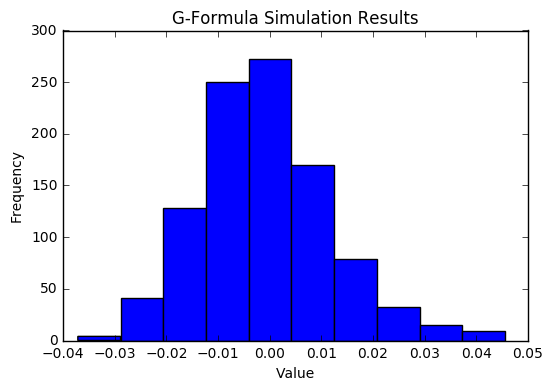

In [49]:
%matplotlib inline
plt.hist(results_g_formula)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

(array([   1.,    1.,    1.,    1.,  992.,    0.,    1.,    1.,    0.,    2.]),
 array([-0.31307606, -0.24472614, -0.17637623, -0.10802631, -0.03967639,
         0.02867353,  0.09702344,  0.16537336,  0.23372328,  0.3020732 ,
         0.37042311]),
 <a list of 10 Patch objects>)

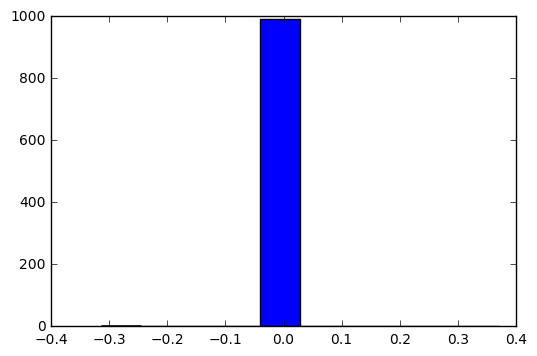

In [41]:
plt.hist(results_dr_estimator)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

In [422]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')

fig = plt.figure()
data = [go.Histogram(x = results_g_formula)]
py.iplot(data)


NameError: name 'results_g_formula' is not defined

In [86]:
fig = plt.figure()
data = [go.Histogram(x = results_dr_estimator)]
py.iplot(data)

In [938]:
trace1 = go.Histogram(
    x=results_g_form_df.difference,
    opacity=0.75, 
    name = "G-formula"
)
trace2 = go.Histogram(
    x=results_dr_bin_df.difference,
    opacity=0.75, 
    name = "DR estimator"
)

data = [trace2, trace1]
layout = go.Layout(barmode='overlay', xaxis = dict(range = [-0.1, 0.1]))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid_histogram')

In [1136]:
results_effect_df2

trace1 = go.Histogram(
    x=results_effect_df2.differenceg,
    opacity=0.75, 
    name = "G-formula"
)
trace2 = go.Histogram(
    x=results_effect_df2.differencedr,
    opacity=0.75, 
    name = "DR estimator"
)

data = [trace2, trace1]
layout = go.Layout(barmode='overlay', xaxis = dict(range = [-0.1, 0.1]))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid_histogram_weffect')

In [942]:
print(np.mean(np.absolute(results_dr_bin_df.difference)))
print(np.mean(np.absolute(results_g_form_df.difference)))

0.030767222441063457
0.015947726700425487


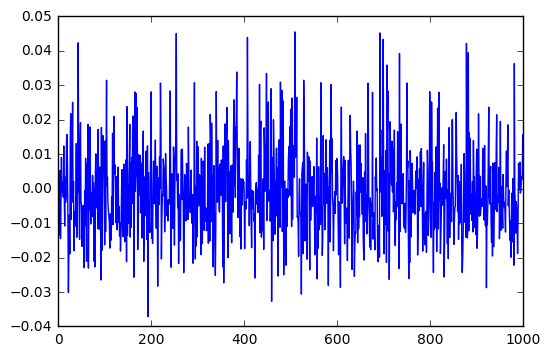

In [42]:
plt.plot(results_g_formula)

In [96]:
results_g_form_df

trace1 = go.Scatter(
    x=results_g_form_df.difference,
    name='G Form'
)
trace2 = go.Scatter(
    x=results_dr_bin_df.difference,
    name='LR DR'
)
data = [trace1, trace2]
layout = go.Layout(xaxis = dict(range = [-0.1, 0.1]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

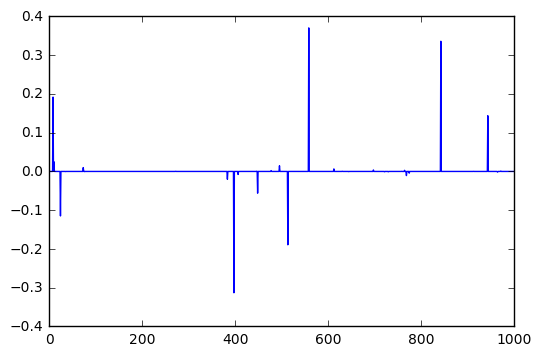

In [43]:
plt.plot(results_dr_estimator)

In [301]:
len(df+1)

12000

In [303]:
len(df)+1

12001